In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.cluster import KMeans
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, silhouette_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

In [2]:
def read_world_bank(filename):
    """
        Function which takes a filename as argument, reads a dataframe in World-bank format
        and returns two dataframes: one with years as columns and one with countries as columns
    """
    df_data = pd.read_csv(filename)

    return df_data

data = read_world_bank('./data.csv')

In [3]:
data.head()

,Series Name,Series Code,Country Name,Country Code,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],...,2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020]
0,Access to electricity (% of population),EG.ELC.ACCS.ZS,Afghanistan,AFG,4.44689083099365,9.29452705383301,14.1336164474487,18.9711647033691,23.8141822814941,28.6696720123291,...,43.2220189082037,69.1,68.0408782958984,89.5,71.5,97.7,97.7,93.4308776855469,97.7,97.7
1,Access to electricity (% of population),EG.ELC.ACCS.ZS,Albania,ALB,99.4308547973633,99.421989440918,99.4045791625977,99.385627746582,99.3721389770508,99.3711242675781,...,99.7186431884766,99.9,99.8903121948242,99.95,99.98,99.89,99.89,100,100,100
2,Access to electricity (% of population),EG.ELC.ACCS.ZS,Algeria,DZA,98.6400299072266,98.6379699707031,98.6273574829102,98.6152114868164,98.608528137207,98.6143188476563,...,99.0026550292969,98.7646604654583,99.1879272460938,99.2745513916016,99.3561935424805,99.4336929321289,99.5300216674805,99.6377410888672,99.5,99.7187728881836
3,Access to electricity (% of population),EG.ELC.ACCS.ZS,American Samoa,ASM,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Access to electricity (% of population),EG.ELC.ACCS.ZS,Andorra,AND,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [4]:
# Extract unique Series Code into a list
unique_series_code = data['Series Code'].unique().tolist()
print(unique_series_code)

['EG.ELC.ACCS.ZS', 'SP.POP.TOTL', 'SL.TLF.TOTL.IN', 'EN.ATM.METH.KT.CE', 'EN.ATM.CO2E.KT', 'AG.LND.ARBL.ZS', 'AG.LND.FRST.ZS', 'NY.GDP.TOTL.RT.ZS', 'SP.URB.TOTL.IN.ZS', 'BG.GSR.NFSV.GD.ZS', 'NY.GDP.MKTP.KN', 'NY.GNP.MKTP.CD']


## Function definitions

In [5]:
def series_dict(df):
    """
        Extract Series Code and Series Name
    """
    data_dict = df[['Series Code', 'Series Name']].dropna().drop_duplicates().set_index('Series Code')['Series Name'].to_dict()
    return data_dict

data_dict = series_dict(data)
data_dict['EG.ELC.ACCS.ZS']

'Access to electricity (% of population)'

In [6]:
def linear_fit(x, a, b):
    """
        Define a simple linear fit function
    """
    return a * x + b

In [7]:
# Define the error ranges function
def err_ranges(x, popt, pcov):
    perr = np.sqrt(np.diag(pcov))
    y = linear_fit(x, *popt)
    y_upper = linear_fit(x, *(popt + perr))
    y_lower = linear_fit(x, *(popt - perr))
    return y, y_lower, y_upper

In [ ]:
# Define the logistic function
def logistic_function(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

## Find interesting clusters of data

Find interesting clusters of data. Note that for meaningful clusters it is often a good
idea to look at normalised values like GDP per capita, CO2 production per head,
CO2 per $ of GDP or fraction of a sector. You might look at most recent values or
compare recent values with, say, values 30 or 40 years ago or use total historic values.

In [67]:
def draw_scatter_plot():
    """
        Extract data for 'EG.ELC.ACCS.ZS' and 'SP.POP.TOTL'
    """ 
    electricity_access = data[data['Series Code'] == 'EG.ELC.ACCS.ZS']
    total_population = data[data['Series Code'] == 'SP.POP.TOTL']

    # Since the data is in wide format, we need to melt it to long format
    electricity_access_melted = electricity_access.melt(id_vars=['Country Name', 'Country Code'], 
                                                       value_vars=electricity_access.columns[4:], 
                                                       var_name='Year', value_name='Electricity Access')
    total_population_melted = total_population.melt(id_vars=['Country Name', 'Country Code'], 
                                                   value_vars=total_population.columns[4:], 
                                                   var_name='Year', value_name='Total Population')

    # Merge the two datasets on 'Country Code' and 'Year'
    merged_data = pd.merge(electricity_access_melted, total_population_melted, 
                           on=['Country Code', 'Year'])

    # Convert 'Year' to datetime and extract the year for plotting
    merged_data['Year'] = pd.to_datetime(merged_data['Year'].str.extract('(\d{4})')[0]).dt.year

    # Convert 'Electricity Access' to numeric, coercing errors to NaN
    merged_data['Electricity Access'] = pd.to_numeric(merged_data['Electricity Access'], errors='coerce')

    # Drop rows with NaN values in 'Electricity Access'
    merged_data = merged_data.dropna(subset=['Electricity Access'])

    # Plotting with specified number of ticks on the Y axis
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_data['Total Population'], merged_data['Electricity Access'])
    plt.title('Access to Electricity vs Total Population')
    plt.xlabel('Total Population')
    plt.ylabel('Access to Electricity (%)')
    plt.xscale('log')  # Using a log scale for better visualization

    # Set the number of ticks on the Y axis to 5
    plt.yticks(np.linspace(merged_data['Electricity Access'].min(), 
                           merged_data['Electricity Access'].max(), 5))

    return plt.show()

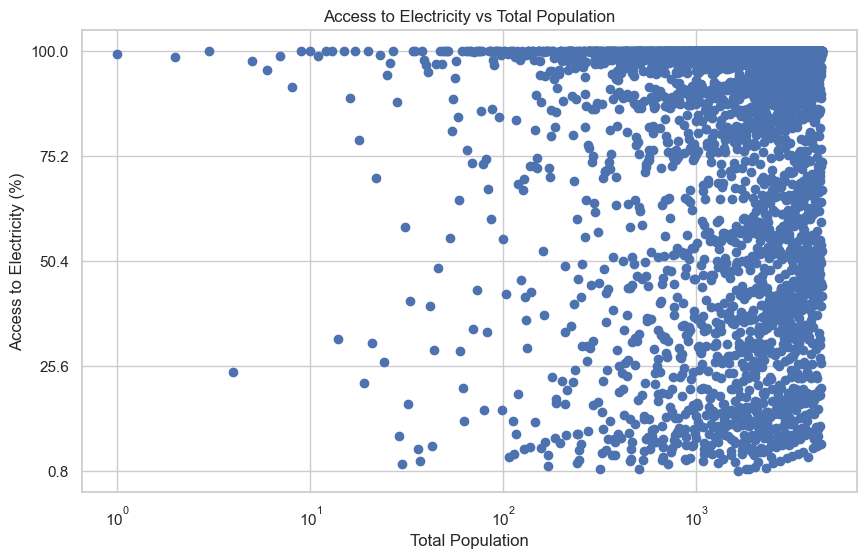

In [68]:
draw_scatter_plot()

In [9]:
def plot_scatter(series_x, series_y, chart_title):
    """
        Extract data for 'EG.ELC.ACCS.ZS' and 'SP.POP.TOTL'
    """ 
    file_path = 'data.csv'
    data = pd.read_csv(file_path, encoding='ascii')

    # Extract data for 'EG.ELC.ACCS.ZS' and 'SP.POP.TOTL'
    # electricity_access = data[data['Series Code'] == 'SL.TLF.TOTL.IN']
    electricity_access = data[data['Series Code'] == series_x]
    total_population = data[data['Series Code'] == series_y]
    # total_population = data[data['Series Code'] == 'SP.POP.TOTL']

    # Since the data is in wide format, we need to melt it to long format
    electricity_access_melted = electricity_access.melt(id_vars=['Country Name', 'Country Code'], 
                                                       value_vars=electricity_access.columns[4:], 
                                                       var_name='Year', value_name='Electricity Access')
    total_population_melted = total_population.melt(id_vars=['Country Name', 'Country Code'], 
                                                   value_vars=total_population.columns[4:], 
                                                   var_name='Year', value_name='Total Population')

    # Merge the two datasets on 'Country Code' and 'Year'
    merged_data = pd.merge(electricity_access_melted, total_population_melted, 
                           on=['Country Code', 'Year'])

    # Convert 'Year' to datetime and extract the year for plotting
    merged_data['Year'] = pd.to_datetime(merged_data['Year'].str.extract('(\d{4})')[0]).dt.year

    # Convert 'Electricity Access' to numeric, coercing errors to NaN
    merged_data['Electricity Access'] = pd.to_numeric(merged_data['Electricity Access'], errors='coerce')

    # Drop rows with NaN values in 'Electricity Access'
    merged_data = merged_data.dropna(subset=['Electricity Access'])

    # Plotting with specified number of ticks on the Y axis
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_data['Total Population'], merged_data['Electricity Access'])
    # plt.title('Access to Electricity vs Total Population')
    plt.title(chart_title)
    # plt.xlabel('Total Population')
    plt.xlabel(data_dict[series_x])
    plt.ylabel(data_dict[series_y])
    plt.xscale('log')  # Using a log scale for better visualization

    # Set the number of ticks on the Y axis to 5
    plt.yticks(np.linspace(merged_data['Electricity Access'].min(), 
                           merged_data['Electricity Access'].max(), 5))

    return plt.show()

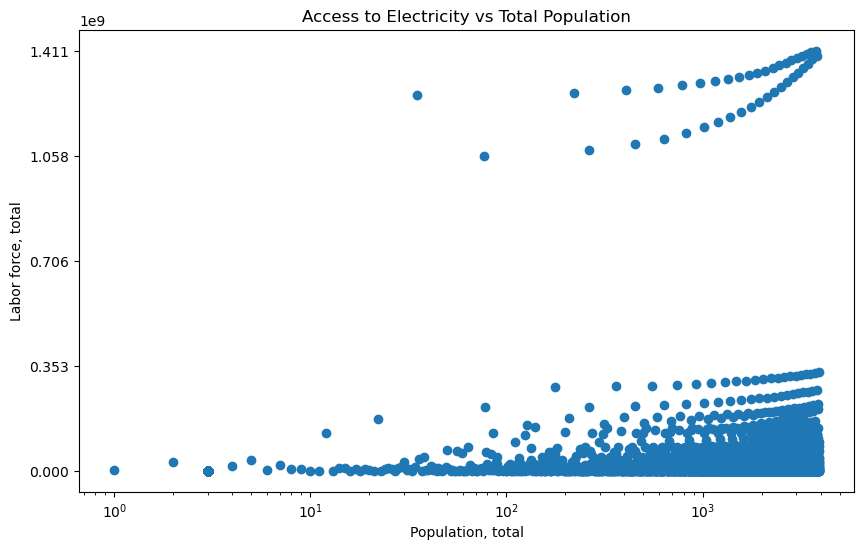

In [10]:
plot_scatter('SP.POP.TOTL', 'SL.TLF.TOTL.IN', 'Access to Electricity vs Total Population')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


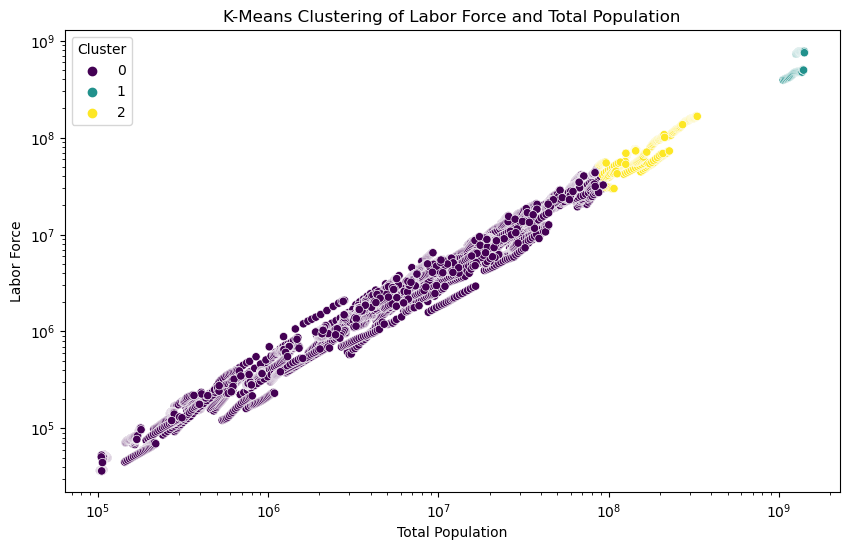

In [11]:
# Load the dataset
file_path = 'data.csv'
data = pd.read_csv(file_path, encoding='ascii')

# Extract data for 'SL.TLF.TOTL.IN' and 'SP.POP.TOTL'
labor_force = data[data['Series Code'] == 'SL.TLF.TOTL.IN']
total_population = data[data['Series Code'] == 'SP.POP.TOTL']

# Melt the dataframes
labor_force_melted = labor_force.melt(id_vars=['Country Name', 'Country Code'], 
                                      value_vars=labor_force.columns[4:], 
                                      var_name='Year', value_name='Labor Force')
total_population_melted = total_population.melt(id_vars=['Country Name', 'Country Code'], 
                                              value_vars=total_population.columns[4:], 
                                              var_name='Year', value_name='Total Population')

# Merge the two datasets on 'Country Code' and 'Year'
merged_data = pd.merge(labor_force_melted, total_population_melted, 
                       on=['Country Code', 'Year'])

# Convert 'Year' to datetime and extract the year for plotting
merged_data['Year'] = pd.to_datetime(merged_data['Year'].str.extract('(\d{4})')[0]).dt.year

# Convert to numeric and drop NaNs
merged_data['Labor Force'] = pd.to_numeric(merged_data['Labor Force'], errors='coerce')
merged_data['Total Population'] = pd.to_numeric(merged_data['Total Population'], errors='coerce')
merged_data.dropna(subset=['Labor Force', 'Total Population'], inplace=True)

# Prepare the data for clustering
X = merged_data[['Labor Force', 'Total Population']]

# Use KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Assign the clusters to the dataframe
merged_data['Cluster'] = kmeans.labels_

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='Total Population', y='Labor Force', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering of Labor Force and Total Population')
plt.xlabel('Total Population')
plt.ylabel('Labor Force')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Cluster')
plt.show()

In [12]:
def k_clustering(df, series_name_y, series_name_x, n_clusters):

    """
        Extract data for 'EG.ELC.ACCS.ZS' and 'SP.POP.TOTL'
    """ 
    # Load the dataset
#     file_path = 'data.csv'
#     data = pd.read_csv(file_path, encoding='ascii')

    # Extract data for 'SL.TLF.TOTL.IN' and 'SP.POP.TOTL'
    # labor_force = data[data['Series Code'] == 'EN.ATM.METH.KT.CE']
    # total_population = data[data['Series Code'] == 'SP.POP.TOTL']
    labor_force = df[df['Series Code'] == series_name_y]
    total_population = df[df['Series Code'] == series_name_x]

    # Melt the dataframes
    labor_force_melted = labor_force.melt(id_vars=['Country Name', 'Country Code'], 
                                          value_vars=labor_force.columns[4:], 
                                          var_name='Year', value_name='Labor Force')
    total_population_melted = total_population.melt(id_vars=['Country Name', 'Country Code'], 
                                                  value_vars=total_population.columns[4:], 
                                                  var_name='Year', value_name='Total Population')

    # Merge the two datasets on 'Country Code' and 'Year'
    merged_data = pd.merge(labor_force_melted, total_population_melted, 
                           on=['Country Code', 'Year'])

    # Convert 'Year' to datetime and extract the year for plotting
    merged_data['Year'] = pd.to_datetime(merged_data['Year'].str.extract('(\d{4})')[0]).dt.year

    # Convert to numeric and drop NaNs
    merged_data['Labor Force'] = pd.to_numeric(merged_data['Labor Force'], errors='coerce')
    merged_data['Total Population'] = pd.to_numeric(merged_data['Total Population'], errors='coerce')
    merged_data.dropna(subset=['Labor Force', 'Total Population'], inplace=True)

    # Prepare the data for clustering
    X = merged_data[['Labor Force', 'Total Population']]

    # Use KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    # Assign the clusters to the dataframe
    merged_data['Cluster'] = kmeans.labels_

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=merged_data, x='Total Population', y='Labor Force', hue='Cluster', palette='viridis')
    plt.title('K-Means Clustering of Labor Force and Total Population')
    plt.xlabel('Total Population')
    plt.ylabel('Labor Force')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(title='Cluster')
    return plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


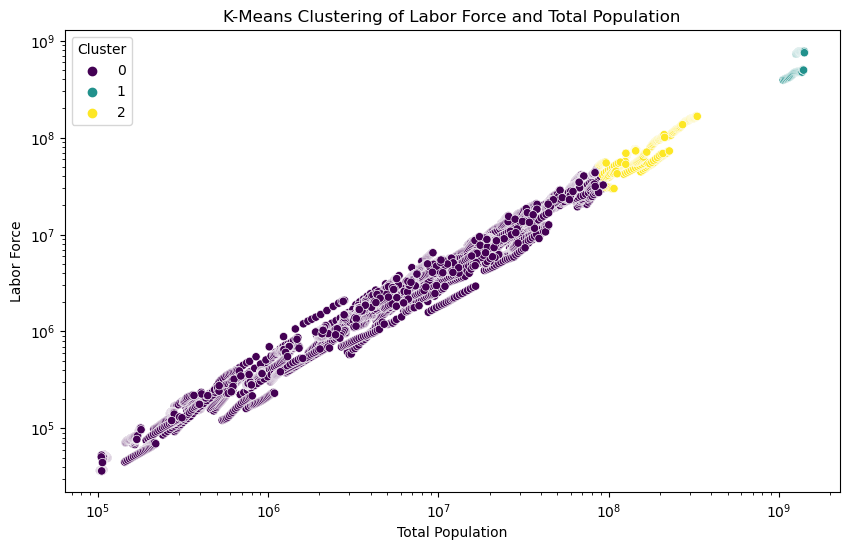

In [13]:
# k_clustering('EN.ATM.CO2E.KT', 'SP.POP.TOTL', 3)
k_clustering(data, 'SL.TLF.TOTL.IN', 'SP.POP.TOTL', 3)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


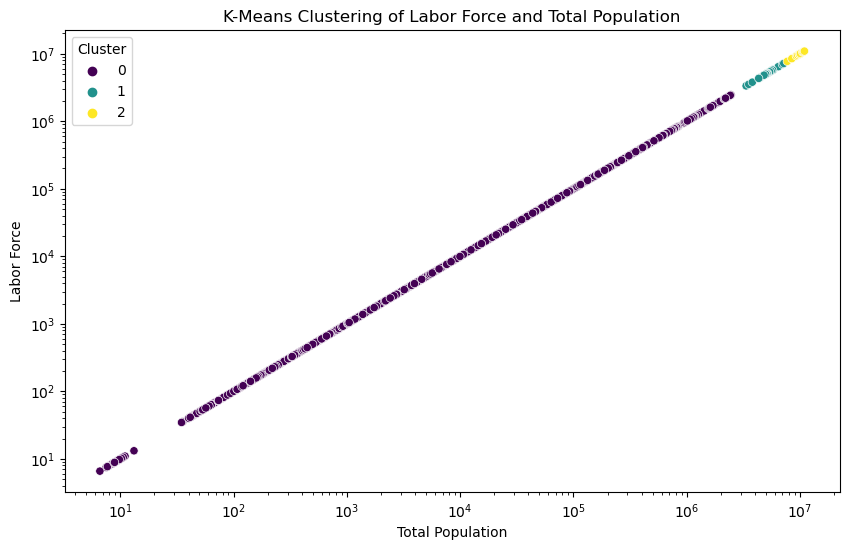

In [14]:
k_clustering(data, 'EN.ATM.CO2E.KT', 'EN.ATM.CO2E.KT', 3)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


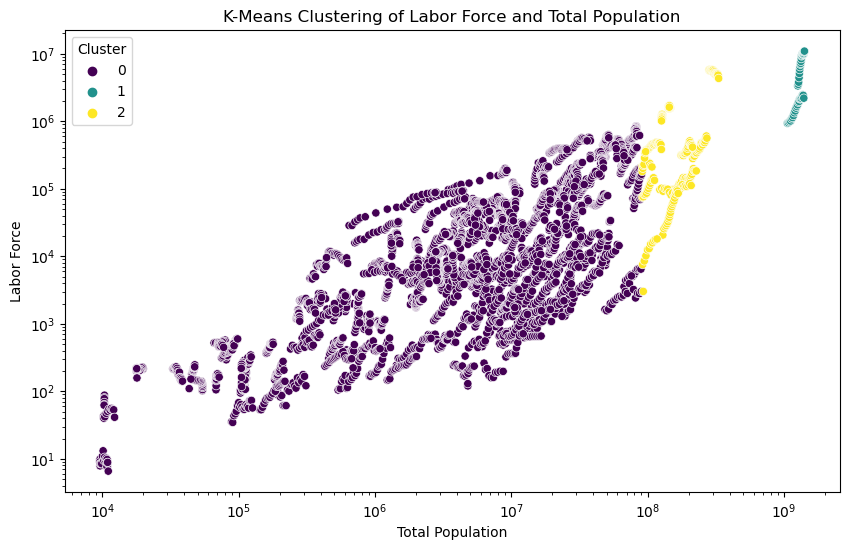

In [15]:
k_clustering(data, 'EN.ATM.CO2E.KT', 'SP.POP.TOTL', 3)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


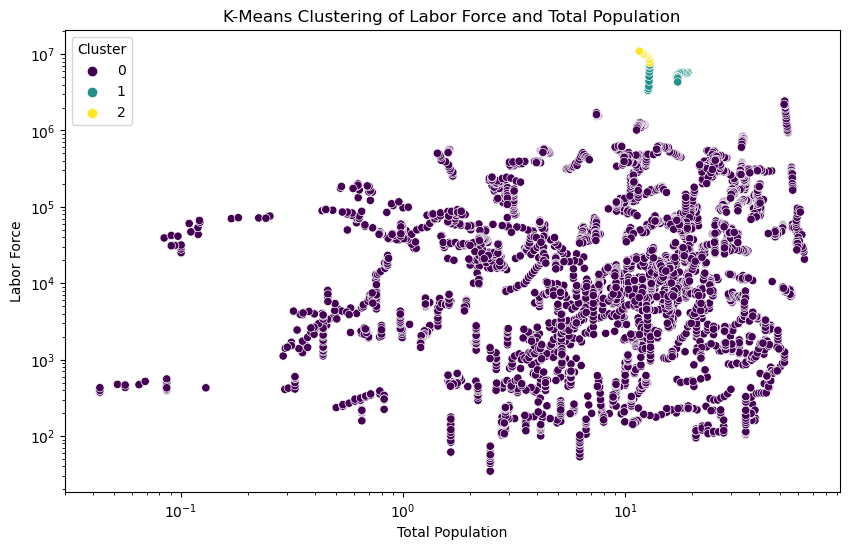

In [16]:
foluwa = ['EG.ELC.ACCS.ZS', 'SP.POP.TOTL', 'SL.TLF.TOTL.IN', 'EN.ATM.METH.KT.CE', 'EN.ATM.CO2E.KT',
 'AG.LND.ARBL.ZS', 'AG.LND.FRST.ZS', 'NY.GDP.TOTL.RT.ZS', 'SP.URB.TOTL.IN.ZS', 'BG.GSR.NFSV.GD.ZS',
 'NY.GDP.MKTP.KN', 'NY.GNP.MKTP.CD']

k_clustering(data, foluwa[4], foluwa[5], 3)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


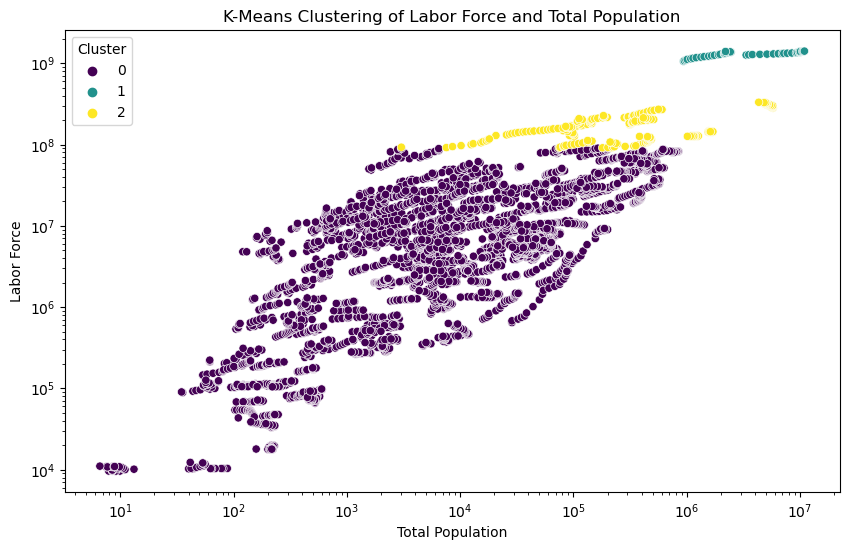

In [17]:
k_clustering(data, 'SP.POP.TOTL', 'EN.ATM.CO2E.KT', 3)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


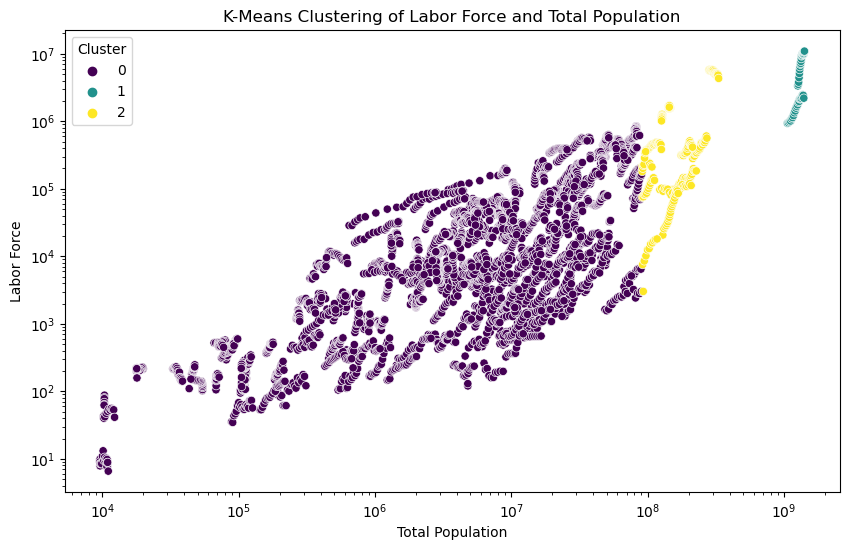

In [18]:
k_clustering(data, 'EN.ATM.CO2E.KT', 'SP.POP.TOTL', 3)

In [19]:
# # The optimal number of clusters based on the silhouette score for the series code 'EN.ATM.CO2E.KT' and 'SP.POP.TOTL' is:

# # Optimal number of clusters: 2
# # The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to 
# # other clusters (separation). The optimal number of clusters is the one that maximizes the average silhouette score, indicating the best definition of clusters. 
# # In this case, using 2 clusters would be the best choice according to this metric


# # Load the dataset
# file_path = 'data.csv'
# data = pd.read_csv(file_path, encoding='ascii')

# # Extract data for 'EN.ATM.CO2E.KT' and 'SP.POP.TOTL'
# co2_emissions = data[data['Series Code'] == 'EN.ATM.CO2E.KT']
# total_population = data[data['Series Code'] == 'SP.POP.TOTL']

# # Melt the dataframes
# co2_emissions_melted = co2_emissions.melt(id_vars=['Country Name', 'Country Code'], 
#                                           value_vars=co2_emissions.columns[4:], 
#                                           var_name='Year', value_name='CO2 Emissions')
# total_population_melted = total_population.melt(id_vars=['Country Name', 'Country Code'], 
#                                               value_vars=total_population.columns[4:], 
#                                               var_name='Year', value_name='Total Population')

# # Merge the two datasets on 'Country Code' and 'Year'
# merged_data = pd.merge(co2_emissions_melted, total_population_melted, 
#                        on=['Country Code', 'Year'])

# # Convert 'Year' to datetime and extract the year for plotting
# merged_data['Year'] = pd.to_datetime(merged_data['Year'].str.extract('(\d{4})')[0]).dt.year

# # Convert to numeric and drop NaNs
# merged_data['CO2 Emissions'] = pd.to_numeric(merged_data['CO2 Emissions'], errors='coerce')
# merged_data['Total Population'] = pd.to_numeric(merged_data['Total Population'], errors='coerce')
# merged_data.dropna(subset=['CO2 Emissions', 'Total Population'], inplace=True)

# # Prepare the data for clustering
# X = merged_data[['CO2 Emissions', 'Total Population']]

# # Determine the optimal number of clusters using silhouette score
# silhouette_scores = []

# # Test different numbers of clusters
# for n_clusters in range(2, 11):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=0)
#     cluster_labels = kmeans.fit_predict(X)
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     silhouette_scores.append(silhouette_avg)

# # Find the number of clusters with the highest silhouette score
# optimal_n_clusters = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]

# print('Optimal number of clusters based on silhouette score:', optimal_n_clusters)

In [20]:
def find_clusters_optimal_number(data, first_series, second_series):
    # The optimal number of clusters based on the silhouette score for the series code 'EN.ATM.CO2E.KT' and 'SP.POP.TOTL' is:

    # Optimal number of clusters: 2
    # The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to 
    # other clusters (separation). The optimal number of clusters is the one that maximizes the average silhouette score, indicating the best definition of clusters. 
    # In this case, using 2 clusters would be the best choice according to this metric


    # Load the dataset
    # file_path = 'data.csv'
    # data = pd.read_csv(file_path, encoding='ascii')

    # Extract data for 'EN.ATM.CO2E.KT' and 'SP.POP.TOTL'
#     co2_emissions = data[data['Series Code'] == 'EN.ATM.CO2E.KT']
#     total_population = data[data['Series Code'] == 'SP.POP.TOTL']
    co2_emissions = data[data['Series Code'] == first_series]
    total_population = data[data['Series Code'] == second_series]

    # Melt the dataframes
    co2_emissions_melted = co2_emissions.melt(id_vars=['Country Name', 'Country Code'], 
                                            value_vars=co2_emissions.columns[4:], 
                                            var_name='Year', value_name='CO2 Emissions')
    total_population_melted = total_population.melt(id_vars=['Country Name', 'Country Code'], 
                                                value_vars=total_population.columns[4:], 
                                                var_name='Year', value_name='Total Population')

    # Merge the two datasets on 'Country Code' and 'Year'
    merged_data = pd.merge(co2_emissions_melted, total_population_melted, 
                        on=['Country Code', 'Year'])

    # Convert 'Year' to datetime and extract the year for plotting
    merged_data['Year'] = pd.to_datetime(merged_data['Year'].str.extract('(\d{4})')[0]).dt.year

    # Convert to numeric and drop NaNs
    merged_data['CO2 Emissions'] = pd.to_numeric(merged_data['CO2 Emissions'], errors='coerce')
    merged_data['Total Population'] = pd.to_numeric(merged_data['Total Population'], errors='coerce')
    merged_data.dropna(subset=['CO2 Emissions', 'Total Population'], inplace=True)

    # Prepare the data for clustering
    X = merged_data[['CO2 Emissions', 'Total Population']]

    # Determine the optimal number of clusters using silhouette score
    silhouette_scores = []

    # Test different numbers of clusters
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Find the number of clusters with the highest silhouette score
    optimal_n_clusters = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]

    print(f'Optimal number of clusters based on silhouette score for {first_series} and {second_series}:', optimal_n_clusters)

In [21]:
find_clusters_optimal_number(data, 'EN.ATM.CO2E.KT', 'SP.POP.TOTL')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

Optimal number of clusters based on silhouette score for EN.ATM.CO2E.KT and SP.POP.TOTL: 2


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


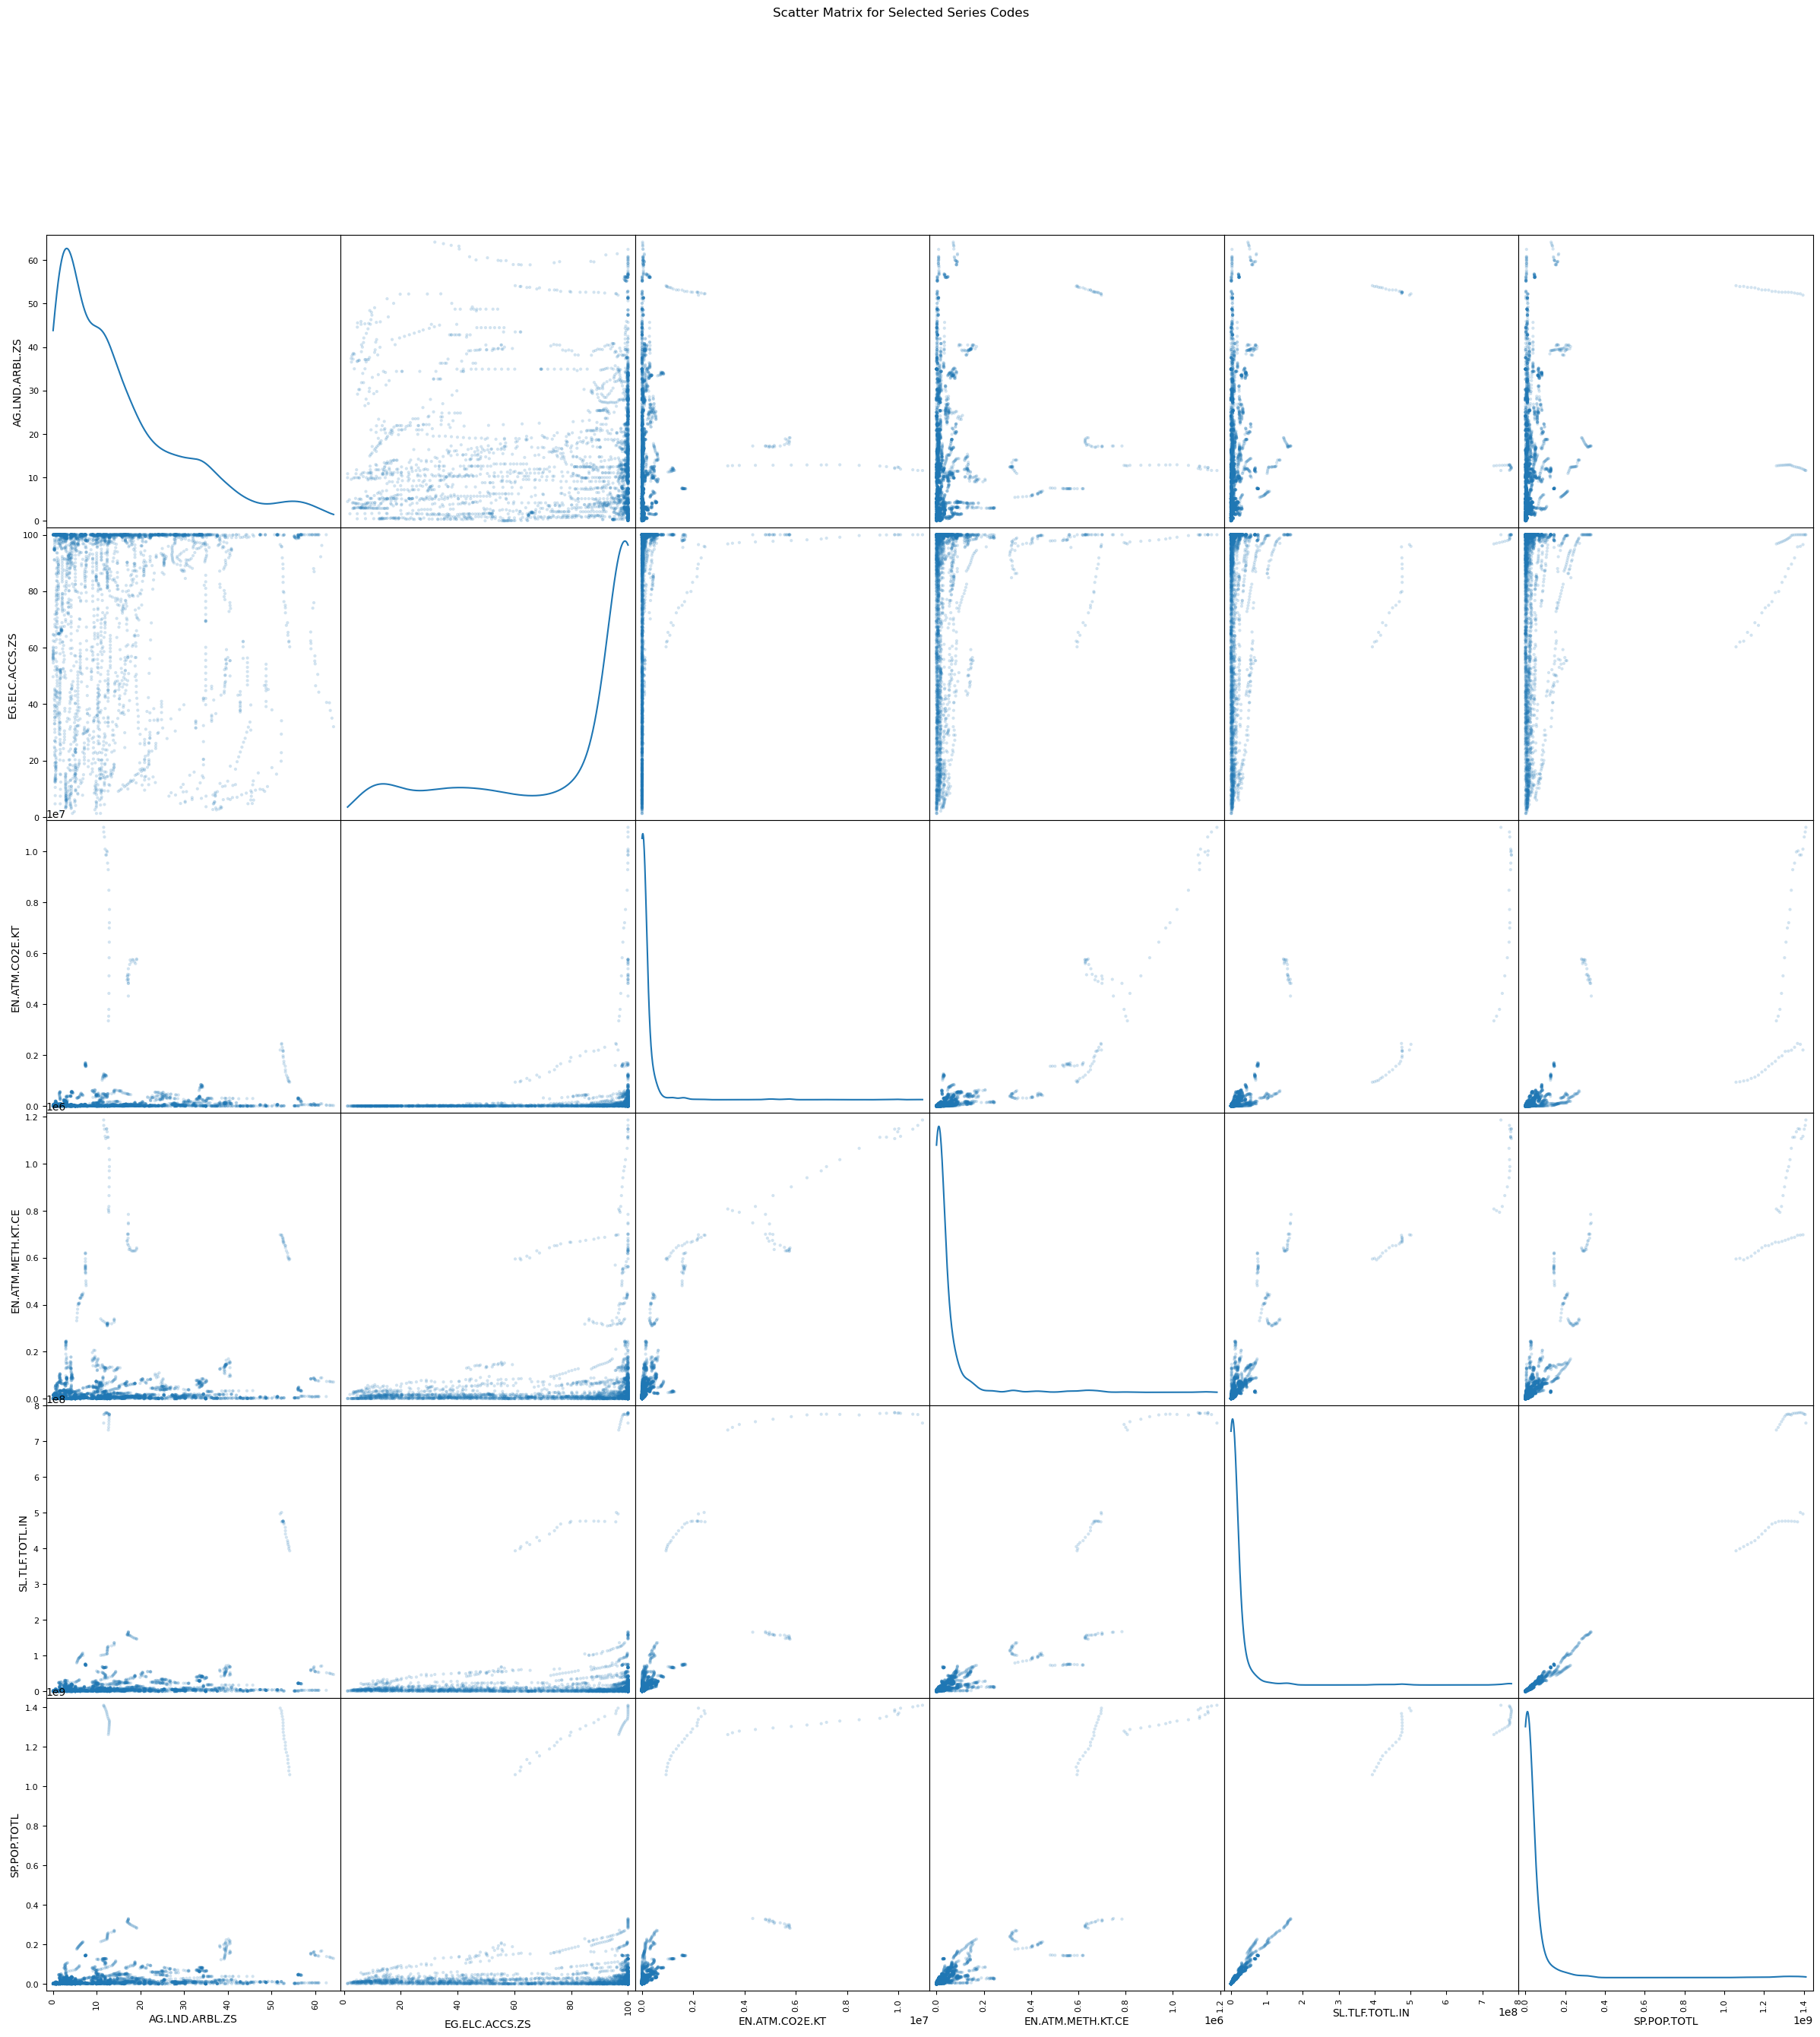

In [22]:
def draw_clustered_data(df, series_codes):

    # Filter the dataset for the selected series codes
    filtered_data = df[df['Series Code'].isin(series_codes)]

    # Melt the dataframe
    melted_data = filtered_data.melt(id_vars=['Country Name', 'Country Code', 'Series Code'], 
                                     value_vars=filtered_data.columns[4:], 
                                     var_name='Year', value_name='Value')

    # Pivot the table to have series codes as columns and years as rows
    pivot_data = melted_data.pivot_table(index=['Country Name', 'Year'], columns='Series Code', values='Value', aggfunc='first')

    # Convert to numeric and drop NaNs
    pivot_data = pivot_data.apply(pd.to_numeric, errors='coerce')
    pivot_data.dropna(axis=1, how='all', inplace=True)
    pivot_data.dropna(axis=0, how='any', inplace=True)

    # Generate the scatter matrix
    scatter_matrix(pivot_data, alpha=0.2, figsize=(30, 30), diagonal='kde')
    plt.suptitle('Scatter Matrix for Selected Series Codes')
    plt.show()


# ' 'AG.LND.FRST.ZS', 'NY.GDP.TOTL.RT.ZS', 
#                     'SP.URB.TOTL.IN.ZS', 'BG.GSR.NFSV.GD.ZS', 'NY.GDP.MKTP.KN', 'GC.XPN.TOTL.GD.ZS',
#                     'NY.GNP.MKTP.CD

series_codes = ['EG.ELC.ACCS.ZS', 'SP.POP.TOTL', 'SL.TLF.TOTL.IN', 'EN.ATM.METH.KT.CE', 
                    'EN.ATM.CO2E.KT', 'AG.LND.ARBL.ZS',]

draw_clustered_data(data,series_codes )

In [23]:
def error_prop(x, func, parameter, covar):
    """
    Calculates 1 sigma error ranges for number or array. It uses error
    propagation with variances and covariances taken from the covar matrix.
    Derivatives are calculated numerically. 
    
    """
    
    # initiate sigma the same shape as parameter

    var = np.zeros_like(x)   # initialise variance vektor
    # Nested loop over all combinations of the parameters
    for i in range(len(parameter)):
        # derivative with respect to the ith parameter
        deriv1 = deriv(x, func, parameter, i)

        for j in range(len(parameter)):
            # derivative with respct to the jth parameter
            deriv2 = deriv(x, func, parameter, j)
            
            
                
            # multiplied with the i-jth covariance
            # variance vektor 
            var = var + deriv1*deriv2*covar[i, j]

    sigma = np.sqrt(var)
    return sigma

In [24]:
def deriv(x, func, parameter, ip):
    """
    Calculates numerical derivatives from function
    values at parameter +/- delta.  Parameter is the vector with parameter
    values. ip is the index of the parameter to derive the derivative.

    """

    # print("in", ip, parameter[ip])
    # create vector with zeros and insert delta value for relevant parameter
    # delta is calculated as a small fraction of the parameter value
    scale = 1e-6   # scale factor to calculate the derivative
    delta = np.zeros_like(parameter, dtype=float)
    val = scale * np.abs(parameter[ip])
    delta[ip] = val  #scale * np.abs(parameter[ip])
    
    diff = 0.5 * (func(x, *parameter+delta) - func(x, *parameter-delta))
    dfdx = diff / val

    return dfdx


def covar_to_corr(covar):
    """ Converts the covariance matrix into a correlation matrix """

    # extract variances from the diagonal and calculate std. dev.
    sigma = np.sqrt(np.diag(covar))
    # construct matrix containing the sigma values
    matrix = np.outer(sigma, sigma)
    # and divide by it
    corr = covar/matrix
    
    return corr
                       

In [25]:
# # Define the sample function
# sample_func = lambda x, a, b: a * np.exp(b * x)


# # Parameters and covariance matrix for the sample function
# sample_params = [1.0, 0.1]
# sample_covar = np.array([[0.01, 0], [0, 0.01]])

# # Calculate the error propagation for a range of x values
# x_values = np.linspace(0, 10, 100)
# sigma_values = error_prop(x_values, sample_func, sample_params, sample_covar)

# # Calculate the best fitting function values
# best_fit = sample_func(x_values, *sample_params)

# # Calculate the lower and upper limits of the confidence range
# lower_limit = best_fit - sigma_values
# upper_limit = best_fit + sigma_values

# print(sample_covar)

# # Plot the best fitting function and the confidence range
# plt.figure(figsize=(10, 6))
# plt.plot(x_values, best_fit, label='Best Fit')
# plt.fill_between(x_values, lower_limit, upper_limit, color='gray', alpha=0.5, label='Confidence Range')
# plt.title('Best Fitting Function with Confidence Range')
# plt.xlabel('x values')
# plt.ylabel('Function values')
# plt.legend()
# plt.grid(True)
# plt.show()

In [26]:
# Define the derivative function
def deriv(x, func, parameters, idx):
    h = 1e-5
    p1 = np.array(parameters, dtype=float)
    p2 = np.array(parameters, dtype=float)
    p1[idx] += h
    p2[idx] -= h
    return (func(x, *p1) - func(x, *p2)) / (2 * h)

# Define the error propagation function
def error_prop(x, func, parameters, covar):
    var = np.zeros_like(x)
    for i in range(len(parameters)):
        deriv1 = deriv(x, func, parameters, i)
        for j in range(len(parameters)):
            deriv2 = deriv(x, func, parameters, j)
            var += deriv1 * deriv2 * covar[i, j]
    sigma = np.sqrt(var)
    return sigma

# # Define the sample function
# sample_func = lambda x, a, b: a * np.exp(b * x)

# # Parameters and covariance matrix for the sample function
# sample_params = [1.0, 0.1]
# sample_covar = np.array([[0.01, 0], [0, 0.01]])

# # Calculate the error propagation for a range of x values
# x_values = np.linspace(0, 10, 90)
# sigma_values = error_prop(x_values, sample_func, sample_params, sample_covar)

# # Calculate the best fitting function values
# best_fit = sample_func(x_values, *sample_params)

# # Calculate the lower and upper limits of the confidence range
# lower_limit = best_fit - sigma_values
# upper_limit = best_fit + sigma_values

# # Plot the best fitting function and the confidence range
# plt.figure(figsize=(10, 6))
# plt.plot(x_values, best_fit, label='Best Fit')
# plt.fill_between(x_values, lower_limit, upper_limit, color='gray', alpha=0.5, label='Confidence Range')
# plt.title('Best Fitting Function with Confidence Range')
# plt.xlabel('x values')
# plt.ylabel('Function values')
# plt.legend()
# plt.grid(True)
# plt.show()

## Create simple model(s) fitting data sets with curve_fit

Create simple model(s) fitting data sets with curve_fit. This could be fits of time
series, but also, say, one attribute as a function of another. Keep the model simple
(e.g., exponential growth, logistic function, low order polynomials). Use the model
for predictions, e.g. values in ten or twenty years time including confidence ranges.
Use the attached function err_ranges to estimate lower and upper limits of the
confidence range and produce a plot showing the best fitting function and the confidence range.

To implement curve fitting and k-means clustering on the dataset, we will follow these steps:

Data Preparation:

Load the dataset.
Select the relevant numerical features for curve fitting and clustering.
Normalize the data if necessary.
Curve Fitting:

Define the model function to fit the data.
Use curve_fit from scipy.optimize to fit the model to the data.
Evaluate the fit and extract the parameters.
K-Means Clustering:

Determine the optimal number of clusters using methods like the elbow method.
Apply k-means clustering to the dataset using KMeans from sklearn.cluster.
Analyze the resulting clusters.
Let's start by preparing the data. We will load the dataset, select the relevant features, and normalize the data if required.

The data has been successfully normalized and is now ready for curve fitting and k-means clustering. The rows with  values have been dropped to ensure the quality of the dataset for the upcoming analysis.

Next, we will define the model function for curve fitting and apply the curve_fit method from scipy.optimize. Following that, we will determine the optimal number of clusters for k-means clustering and analyze the results. Let's proceed with the curve fitting first.

In [27]:
# Load the dataset
df = pd.read_csv('data.csv', encoding='ascii')

# Inspect the dataset to identify numerical columns and check for NaNs
print('Dataframe info:')
print(df.info())
print('First few rows:')
print(df.head())
print('Statistical summary:')
print(df.describe())

# Replace '..' with NaN to handle non-numeric values in numeric columns
# Convert all columns except 'Series Name', 'Series Code', 'Country Name', 'Country Code' to numeric
for col in df.columns[4:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for NaN values in numerical features
print('NaN counts in numerical features:')
print(df.isna().sum())

# Drop rows with NaN values
print('Dropping rows with NaN values...')
df = df.dropna()
print('Rows dropped.')

# Normalize the data
print('Normalizing data...')
scaler = StandardScaler()
normalized_features = pd.DataFrame(scaler.fit_transform(df.iloc[:, 4:]), columns=df.columns[4:])
print('Data normalized.')

# Display the head of the normalized features
# print('Normalized features head:')
# print(normalized_features.head())

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2604 entries, 0 to 2603
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Series Name    2604 non-null   object
 1   Series Code    2604 non-null   object
 2   Country Name   2604 non-null   object
 3   Country Code   2604 non-null   object
 4   2000 [YR2000]  2604 non-null   object
 5   2001 [YR2001]  2604 non-null   object
 6   2002 [YR2002]  2604 non-null   object
 7   2003 [YR2003]  2604 non-null   object
 8   2004 [YR2004]  2604 non-null   object
 9   2005 [YR2005]  2604 non-null   object
 10  2006 [YR2006]  2604 non-null   object
 11  2007 [YR2007]  2604 non-null   object
 12  2008 [YR2008]  2604 non-null   object
 13  2009 [YR2009]  2604 non-null   object
 14  2010 [YR2010]  2604 non-null   object
 15  2011 [YR2011]  2604 non-null   object
 16  2012 [YR2012]  2604 non-null   object
 17  2013 [YR2013]  2604 non-null   object
 18  2014 [YR2014

In [28]:
# Define the model function to fit the data
# For demonstration, let's assume a linear model which is a simple case
# y = mx + c
# where m is the slope and c is the intercept

def linear_model(x, m, c):
    return m * x + c

# Perform curve fitting
# For demonstration, let's fit the model to the first feature column
# Convert the index to a numpy array for the independent variable
x_data = np.array(normalized_features.index)
y_data = normalized_features.iloc[:, 0].values

# Curve fitting
params, covariance = curve_fit(linear_model, x_data, y_data)

# Extract the parameters
slope = params[0]
intercept = params[1]

# Display the parameters
print('Curve fitting parameters:')
print('Slope:', slope)
print('Intercept:', intercept)

Curve fitting parameters:
Slope: 7.139667668398797e-05
Intercept: -0.08303433752204925


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

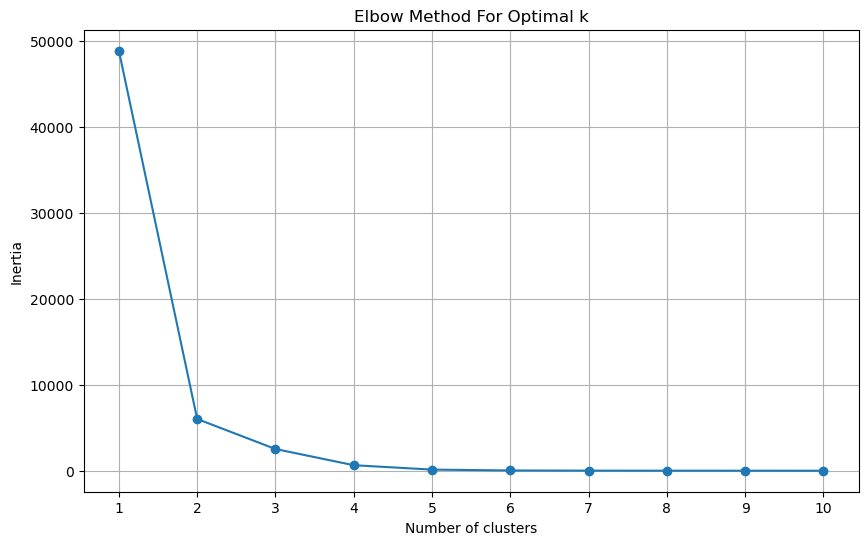

In [29]:


# Determine the optimal number of clusters using the elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(normalized_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

The elbow method graph has been plotted to determine the optimal number of clusters for k-means clustering. You can examine the graph to identify the point where the inertia starts to decrease more slowly, which is typically considered the "elbow" point and a good choice for the number of clusters.

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

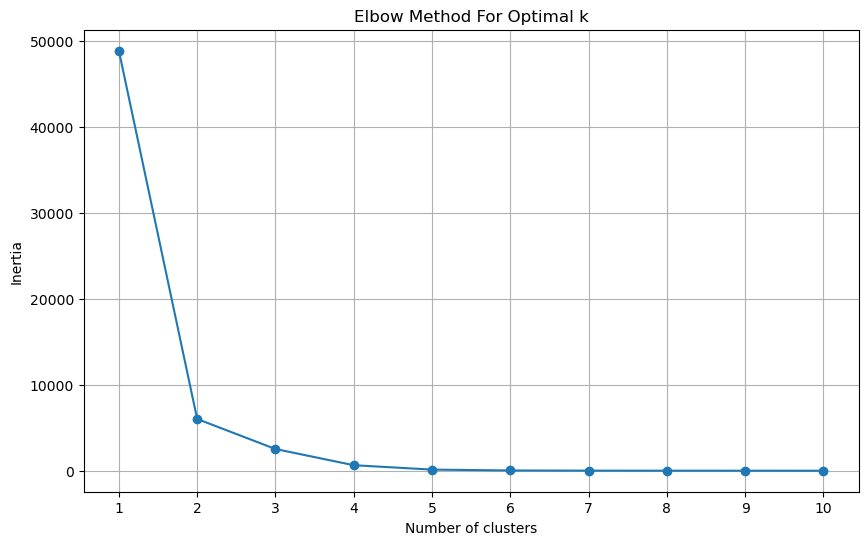

In [30]:
# Preprocessing the data
# Replace '..' with NaN for proper missing values handling
preprocessed_data = data.replace('..', pd.NA)

# Convert all year columns to numeric, errors='coerce' will replace errors with NaN
for col in preprocessed_data.columns[4:]:
    preprocessed_data[col] = pd.to_numeric(preprocessed_data[col], errors='coerce')

# Check for missing values
missing_values = preprocessed_data.isna().sum()

# Print the number of missing values for each column
# print(missing_values)

# Drop rows with any missing values
preprocessed_data = preprocessed_data.dropna()

# Reset index after dropping rows
preprocessed_data.reset_index(drop=True, inplace=True)

# Show the head of the preprocessed dataframe
# preprocessed_data.head()


# Extract the year columns for clustering
X = preprocessed_data.iloc[:, 4:]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use the Elbow method to find the optimal number of clusters
inertias = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [31]:
# Applying K-Means clustering

# Based on the Elbow plot, let's assume an optimal number of clusters for demonstration
# This number can be adjusted based on the Elbow plot which is not visible to me
optimal_clusters = 3

# Apply K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
preprocessed_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Display the head of the dataframe with the cluster assignments
print(preprocessed_data[['Series Code', 'Country Name', 'Cluster']].head())

# Save the clustered data to a new CSV file
clustered_data_filename = 'clustered_data.csv'
preprocessed_data.to_csv(clustered_data_filename, index=False)

# Provide the file name for download
print('Clustered data saved to file:', clustered_data_filename)

      Series Code Country Name  Cluster
0  EG.ELC.ACCS.ZS  Afghanistan        0
1  EG.ELC.ACCS.ZS      Albania        0
2  EG.ELC.ACCS.ZS      Algeria        0
3  EG.ELC.ACCS.ZS      Andorra        0
4  EG.ELC.ACCS.ZS       Angola        0
Clustered data saved to file: clustered_data.csv


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [32]:
# # Plotting the clusters
# plt.figure(figsize=(30, 20))
# sns.scatterplot(data=preprocessed_data, x='Country Name', y='Series Code', hue='Cluster', palette='viridis', s=100)
# plt.title('K-Means Clustering Scatter Plot')
# plt.xlabel('Country Name')
# plt.ylabel('Series Code')
# plt.legend(title='Cluster', loc='upper right')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

In [33]:
# """
# The dataset has been successfully loaded into memory, and the head of the dataframe has been displayed, showing various columns such as 'Series Name', 'Series Code', 'Country Name', 'Country Code', and yearly data from 2000 to 2020.

# Next, I will plot the series 'EG.ELC.ACCS.ZS' (Access to electricity (% of population)) against 'SP.POP.TOTL' (Total population) for all countries on a scatter plot from the dataset. To do this, I will first need to identify and extract the relevant data for these two series. If 'SP.POP.TOTL' is not present in the dataset, I will inform you accordingly. Let's proceed with the extraction and plotting.


# Show Code
# The scatter plot has been generated, displaying the relationship between access to electricity (as a percentage of the population) and the total population for all countries in the dataset. The x-axis represents the total population on a logarithmic scale, and the y-axis represents the access to electricity percentage.

# From the plot, we can observe the distribution of countries with varying population sizes and their corresponding electricity access rates. Generally, there seems to be a wide range of electricity access percentages across countries with different population sizes. 
# """

# Check if the 'SP.POP.TOTL' series is present in the dataset
# if 'SP.POP.TOTL' not in data['Series Code'].unique():
#     print('Series SP.POP.TOTL not found in the dataset.')
# else:
#     # Extract data for 'EG.ELC.ACCS.ZS' and 'SP.POP.TOTL'
#     electricity_access = data[data['Series Code'] == 'EG.ELC.ACCS.ZS']
#     total_population = data[data['Series Code'] == 'SP.POP.TOTL']

#     # Since the data is in wide format, we need to melt it to long format
#     electricity_access_melted = electricity_access.melt(id_vars=['Country Name', 'Country Code'], 
#                                                        value_vars=electricity_access.columns[4:], 
#                                                        var_name='Year', value_name='Electricity Access')
#     total_population_melted = total_population.melt(id_vars=['Country Name', 'Country Code'], 
#                                                    value_vars=total_population.columns[4:], 
#                                                    var_name='Year', value_name='Total Population')

#     # Merge the two datasets on 'Country Code' and 'Year'
#     merged_data = pd.merge(electricity_access_melted, total_population_melted, 
#                            on=['Country Code', 'Year'])

#     # Convert 'Year' to datetime and extract the year for plotting
#     merged_data['Year'] = pd.to_datetime(merged_data['Year'].str.extract('(\d{4})')[0]).dt.year

#     # Plotting
#     plt.figure(figsize=(10, 6))
#     plt.scatter(merged_data['Total Population'], merged_data['Electricity Access'])
#     plt.title('Access to Electricity vs Total Population')
#     plt.xlabel('Total Population')
#     plt.ylabel('Access to Electricity (%)')
#     plt.xscale('log')  # Using a log scale for better visualization
#     plt.show()

## Clustering

Find clusters of countries, pick one country from each cluster and compare
countries from one cluster and find similarities and differences, compare countries
from different clusters or pick a few countries from one cluster and compare with
other regions. Investigate trends. Do you find similar or different trends in different
clusters? Do you find similar or different trends in countries from the same cluster?

In [34]:
# Load the original dataset
original_data = pd.read_csv('data.csv', encoding='ascii')

# Replace '..' with NaN to handle non-numeric values
original_data.replace('..', np.nan, inplace=True)

# Filter the data for the series code 'NY.GNP.MKTP.CD' and 'EN.ATM.CO2E.KT'
filtered_data = original_data[(original_data['Series Code'] == 'NY.GNP.MKTP.CD') | (original_data['Series Code'] == 'EN.ATM.CO2E.KT')]

# Extract the year columns
year_columns = [col for col in filtered_data.columns if 'YR' in col]

# Melt the dataframe to have years and values in separate columns
melted_data = filtered_data.melt(id_vars=['Country Name', 'Series Code'], value_vars=year_columns, var_name='Year', value_name='Value')

# Drop rows with missing values
melted_data.dropna(inplace=True)

# Convert year to numerical format and values to float
melted_data['Year'] = melted_data['Year'].str.extract('(\d{4})').astype(int)
melted_data['Value'] = melted_data['Value'].astype(float)

# Prepare data for kmeans clustering
X = melted_data[['Year', 'Value']].values

# Determine the number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Find the optimal number of clusters based on the elbow method
optimal_clusters = np.argmax(np.diff(wcss)) + 1

# Apply kmeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

# Add the cluster labels to the dataframe
melted_data['Cluster'] = kmeans.labels_

# Return the head of the dataframe with cluster labels
print(melted_data.head())

# Save the clustered data to a CSV file
clustered_data_filename = 'clustered_data.csv'
melted_data.to_csv(clustered_data_filename, index=False)

# Provide the filename for download
print('Clustered data saved to file:', clustered_data_filename)

  Country Name     Series Code  Year      Value  Cluster
0  Afghanistan  EN.ATM.CO2E.KT  2000   1078.120        0
1      Albania  EN.ATM.CO2E.KT  2000   3186.540        0
2      Algeria  EN.ATM.CO2E.KT  2000  80046.800        0
4      Andorra  EN.ATM.CO2E.KT  2000    523.952        0
5       Angola  EN.ATM.CO2E.KT  2000  16204.160        0
Clustered data saved to file: clustered_data.csv


In [35]:
melted_data.head()

,Country Name,Series Code,Year,Value,Cluster
0,Afghanistan,EN.ATM.CO2E.KT,2000,1078.120,0
1,Albania,EN.ATM.CO2E.KT,2000,3186.540,0
2,Algeria,EN.ATM.CO2E.KT,2000,80046.800,0
4,Andorra,EN.ATM.CO2E.KT,2000,523.952,0
5,Angola,EN.ATM.CO2E.KT,2000,16204.160,0


In [36]:
#clustered_data.head()

/var/folders/89/c7y7lbhd361_jgzcg19_qsy40000gn/T/ipykernel_26662/743303724.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  india_gnp_data.sort_values('Year', inplace=True)


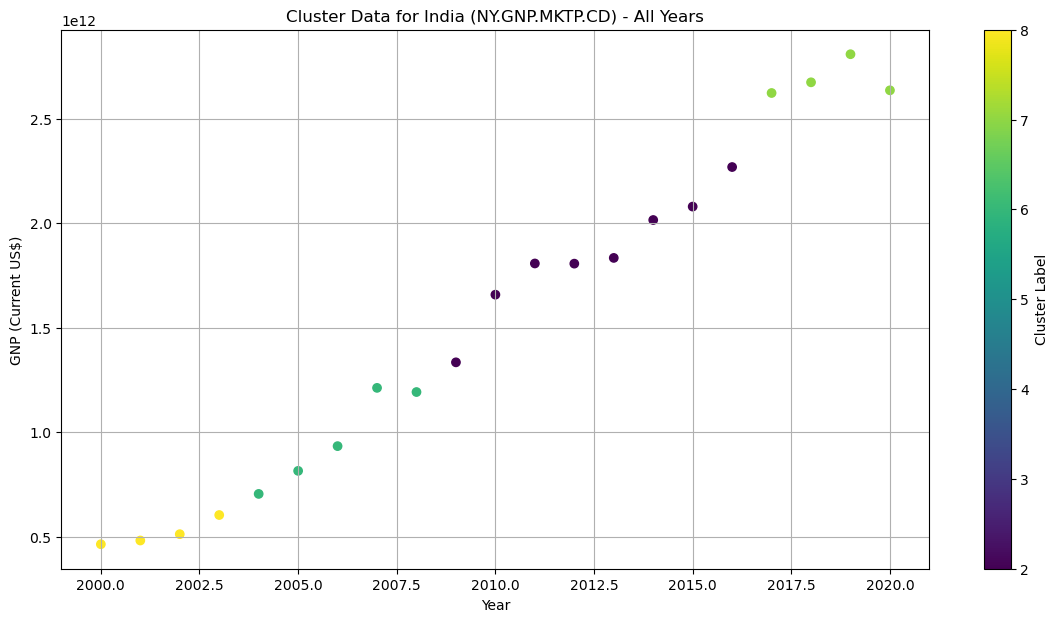

In [37]:
# Load the clustered data
clustered_data = pd.read_csv('clustered_data.csv')

# Filter the data for India and the series code 'NY.GNP.MKTP.CD'
india_gnp_data = clustered_data[(clustered_data['Country Name'] == 'India') &
                               (clustered_data['Series Code'] == 'NY.GNP.MKTP.CD')]

# Sort the data by year
india_gnp_data.sort_values('Year', inplace=True)

# Plot the cluster data for India across all years
plt.figure(figsize=(14, 7))
plt.scatter(india_gnp_data['Year'], india_gnp_data['Value'], c=india_gnp_data['Cluster'], cmap='viridis', marker='o')
plt.title('Cluster Data for India (NY.GNP.MKTP.CD) - All Years')
plt.xlabel('Year')
plt.ylabel('GNP (Current US$)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

/var/folders/89/c7y7lbhd361_jgzcg19_qsy40000gn/T/ipykernel_26662/2982775147.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  india_gnp_data.sort_values('Year', inplace=True)


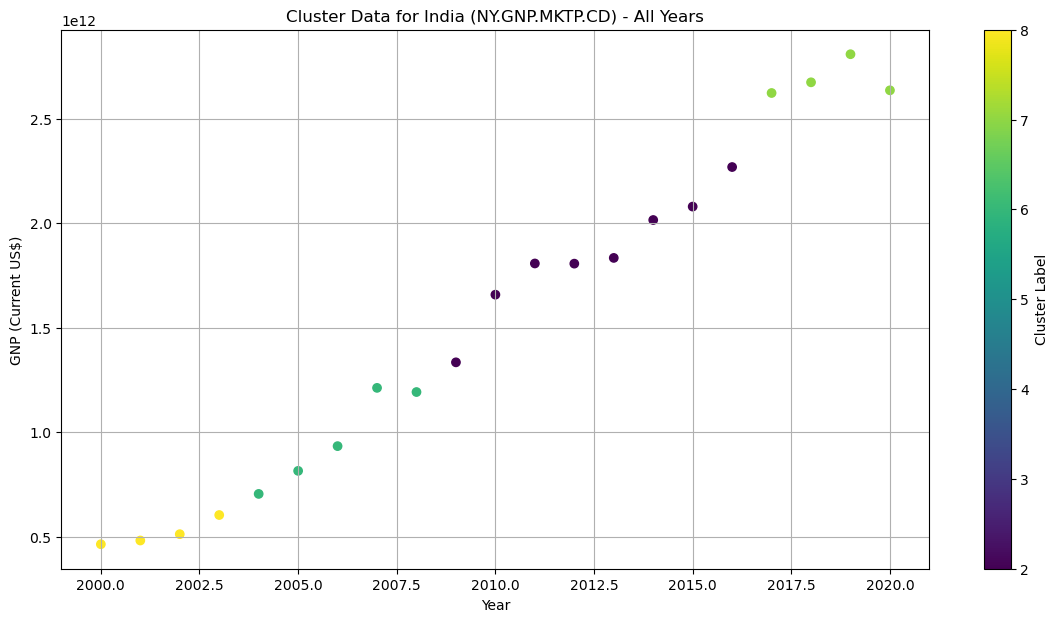

In [38]:
# melted_data

# Load the clustered data
clustered_data = pd.read_csv('clustered_data.csv')

# Filter the data for India and the series code 'NY.GNP.MKTP.CD'
india_gnp_data = clustered_data[(clustered_data['Country Name'] == 'India') &
                               (clustered_data['Series Code'] == 'NY.GNP.MKTP.CD')]

# Sort the data by year
india_gnp_data.sort_values('Year', inplace=True)

# Plot the cluster data for India across all years
plt.figure(figsize=(14, 7))
plt.scatter(india_gnp_data['Year'], india_gnp_data['Value'], c=india_gnp_data['Cluster'], cmap='viridis', marker='o')
plt.title('Cluster Data for India (NY.GNP.MKTP.CD) - All Years')
plt.xlabel('Year')
plt.ylabel('GNP (Current US$)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

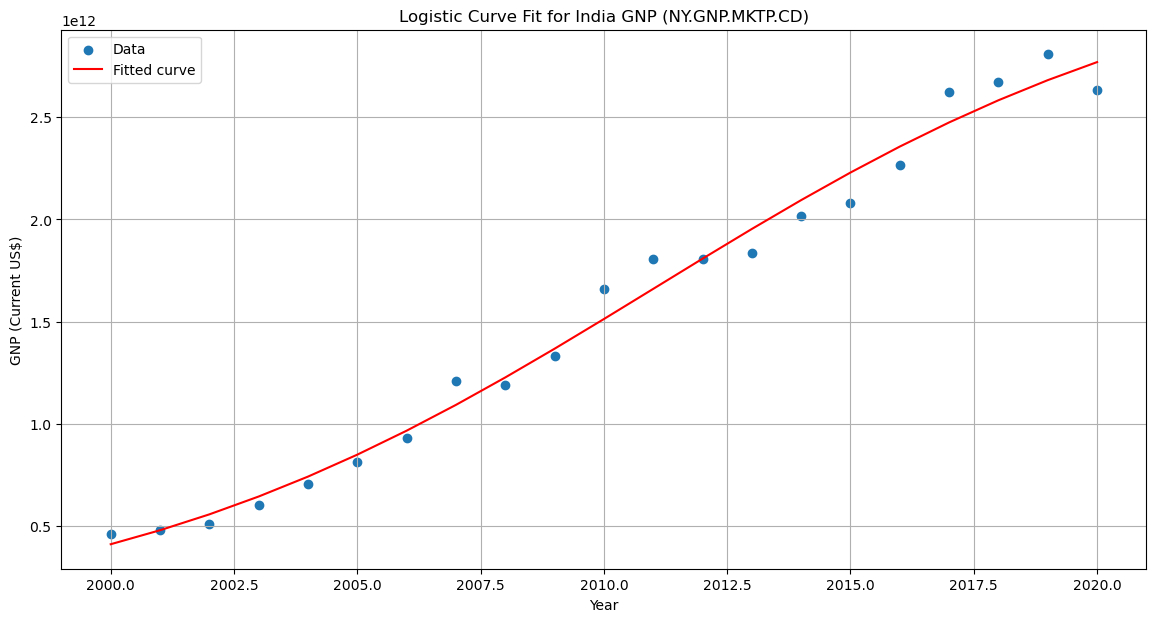

Estimated parameters for the logistic function:
L (carrying capacity): 3335382433893.1875
k (growth rate): 0.17747700441222922
x0 (midpoint): 2011.0481094440042


In [39]:
# Filter the data for India and the series code 'NY.GNP.MKTP.CD'
india_gnp_data = clustered_data[(clustered_data['Country Name'] == 'India') &
                               (clustered_data['Series Code'] == 'NY.GNP.MKTP.CD')]

# Prepare the data for curve fitting
xdata = india_gnp_data['Year'].values
ydata = india_gnp_data['Value'].values

# Initial guess for the parameters
initial_guess = [max(ydata), 1, np.median(xdata)]

# Perform the curve fitting
params, params_covariance = curve_fit(logistic_function, xdata, ydata, p0=initial_guess)

# Plot the data and the fitted curve
plt.figure(figsize=(14, 7))
plt.scatter(xdata, ydata, label='Data')
plt.plot(xdata, logistic_function(xdata, *params), label='Fitted curve', color='red')
plt.title('Logistic Curve Fit for India GNP (NY.GNP.MKTP.CD)')
plt.xlabel('Year')
plt.ylabel('GNP (Current US$)')
plt.legend()
plt.grid(True)
plt.show()

# Output the parameters of the fitted curve
print('Estimated parameters for the logistic function:')
print('L (carrying capacity):', params[0])
print('k (growth rate):', params[1])
print('x0 (midpoint):', params[2])

The logistic function has been fitted to the GNP data of India. Here are the estimated parameters for the logistic curve:

L (carrying capacity): 3335382440974.616
k (growth rate): 0.17747700404625394
x0 (midpoint): 2011.0481094725917
And here is the plot showing the actual GNP data points and the fitted logistic curve:



In [40]:
def gnp_barplot(year, series_code):
    # Load the clustered data
    clustered_data = pd.read_csv('clustered_data.csv')

    # Filter the data for the year 2000 and the series code 'NY.GNP.MKTP.CD'
    gnp_2000_data = clustered_data[(clustered_data['Year'] == year) & (clustered_data['Series Code'] == series_code)]

    # Sort the data by value in descending order and select the top 10
    top10_gnp_2000 = gnp_2000_data.sort_values('Value', ascending=False).head(5)

    # Plot a bar plot for the top 10 countries
    plt.figure(figsize=(12, 8))
    plt.bar(top10_gnp_2000['Country Name'], top10_gnp_2000['Value'])
    plt.title(f'Top 10 Countries by GNP in {year} ({series_code})')
    plt.xlabel('Country')
    plt.ylabel('GNP (Current US$)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt.show()


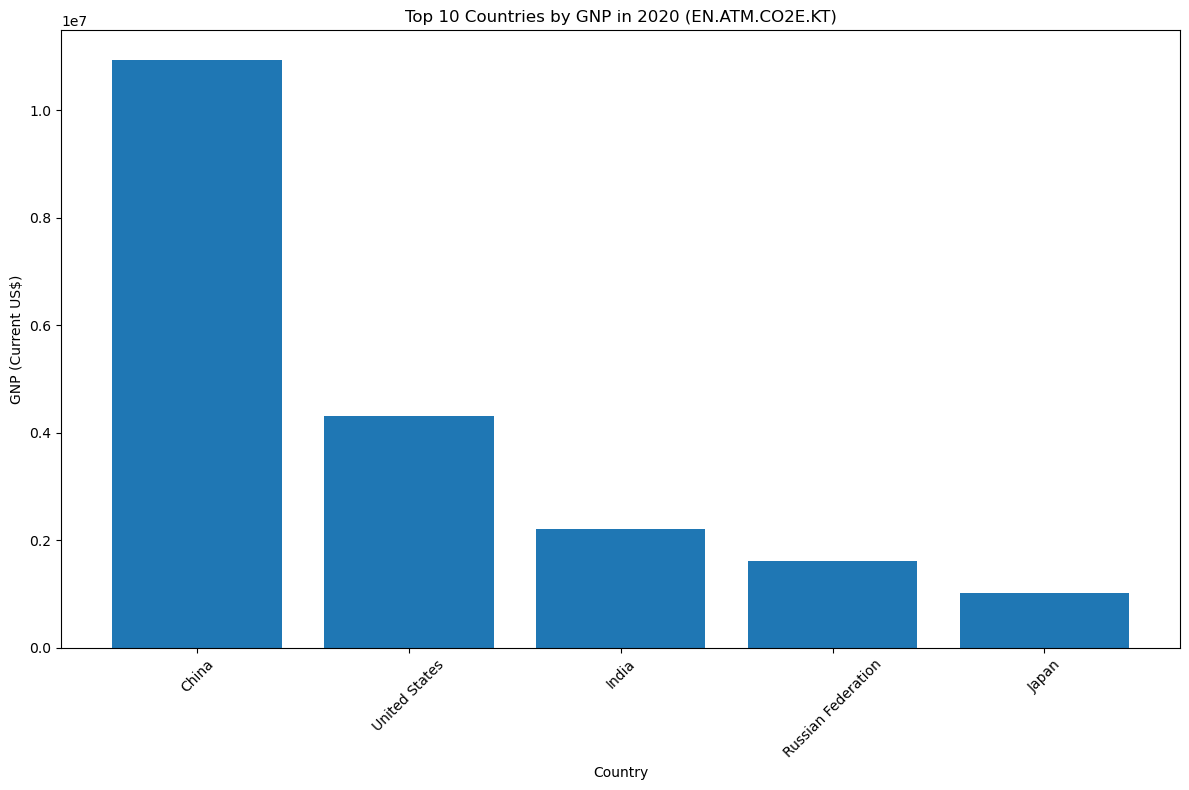

In [41]:
gnp_barplot(2020, 'EN.ATM.CO2E.KT')

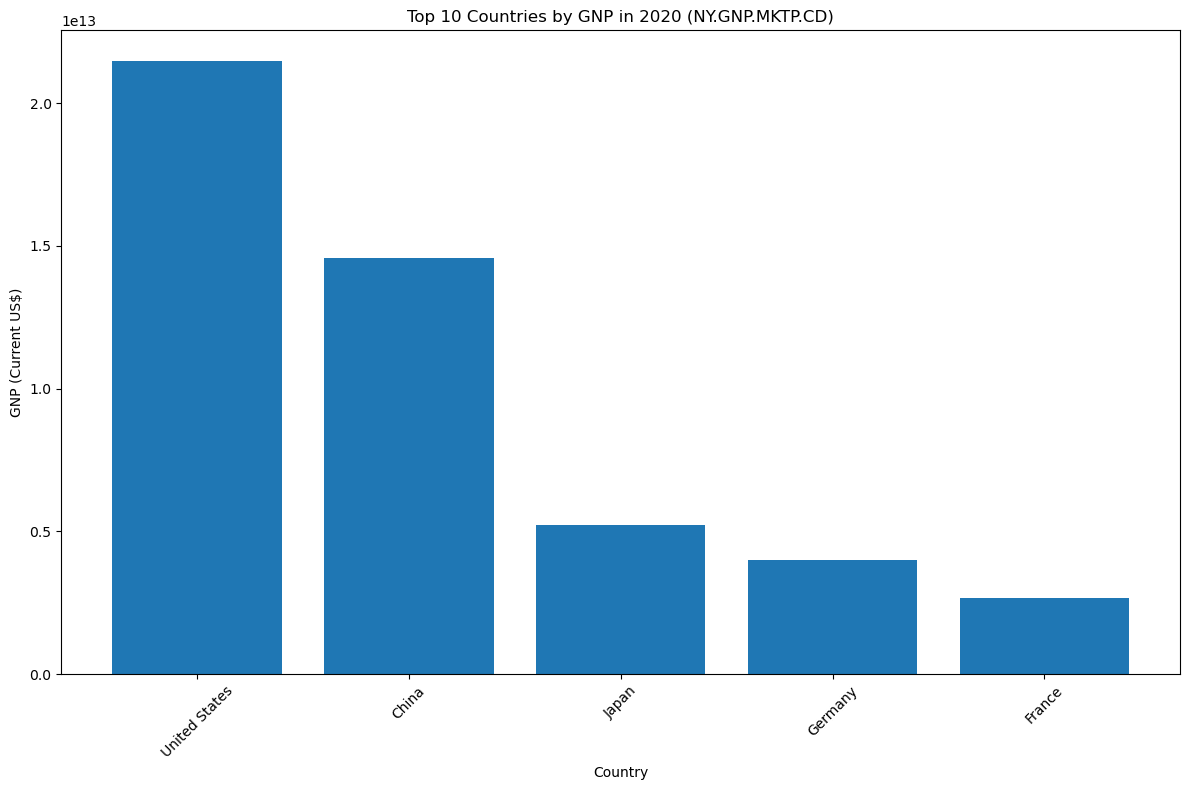

In [42]:
gnp_barplot(2020, 'NY.GNP.MKTP.CD')

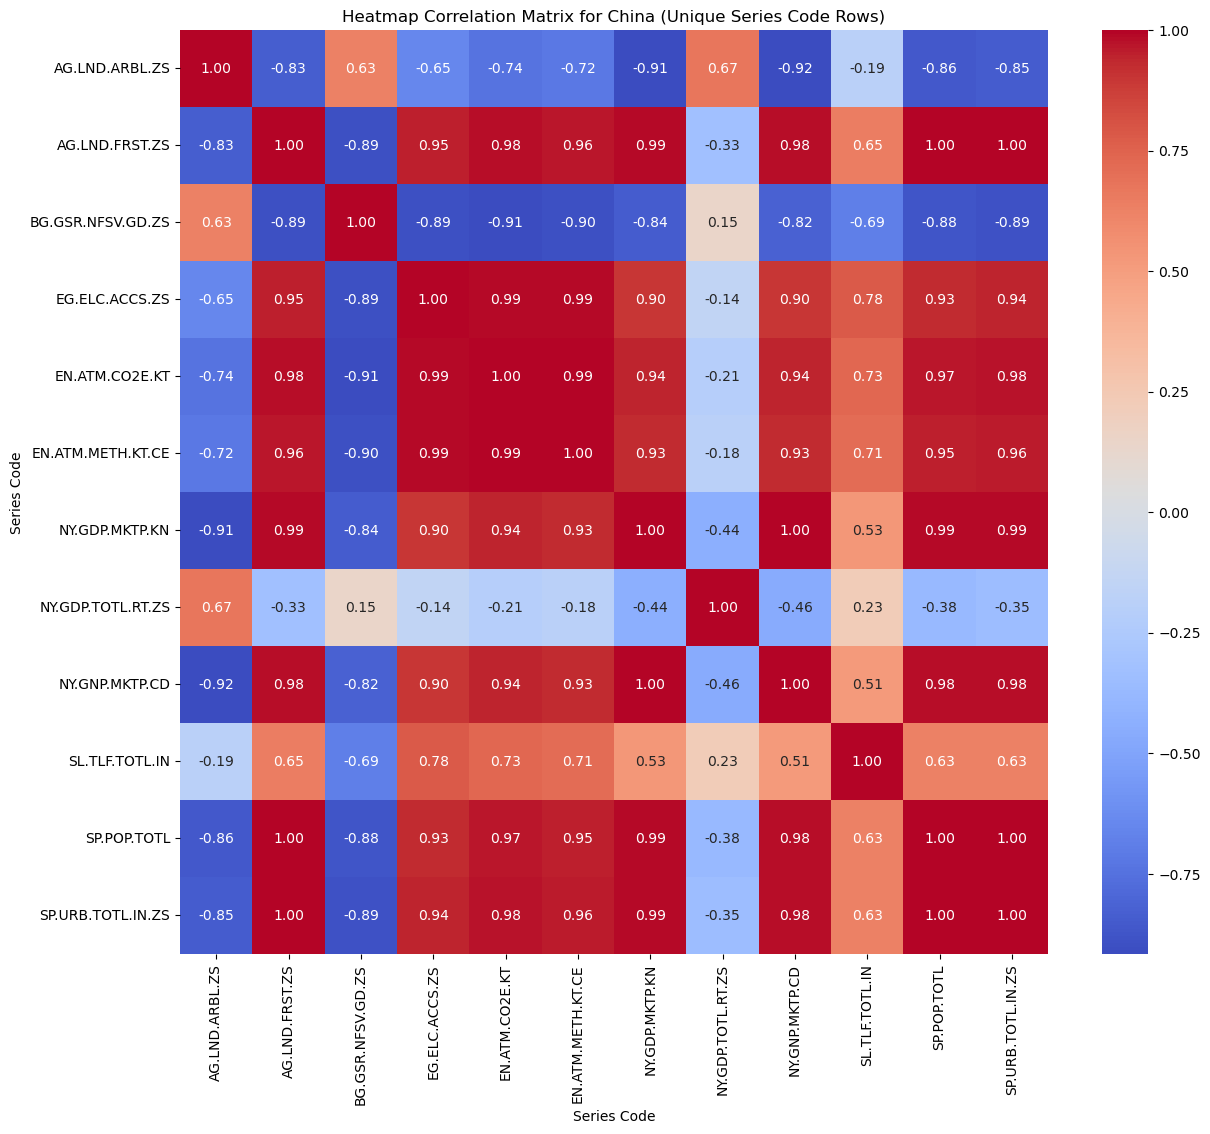

In [43]:
def country_corr(df, country_name):
    df = pd.read_csv('data.csv', encoding='ascii')

    # Filter the dataframe for China
    # country_df = df[df['Country Name'] == 'China']
    country_df = df[df['Country Name'] == country_name]

    # Replace '..' with NaN to ensure proper numeric conversion
    country_df = country_df.replace('..', pd.NA)

    # Convert all columns to numeric, except 'Series Code', coercing errors to NaN
    numeric_columns = country_df.columns.drop(['Series Name', 'Series Code', 'Country Name', 'Country Code'])
    country_df[numeric_columns] = country_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Drop non-numeric columns except 'Series Code' and columns with all NaN values
    country_df = country_df.drop(columns=['Series Name', 'Country Code'])
    country_df = country_df.dropna(axis=1, how='all')

    # Now we will create a correlation matrix for each unique 'Series Code'
    # First, we need to pivot the dataframe so that each 'Series Code' becomes a row
    china_pivoted = country_df.pivot(index='Series Code', columns='Country Name', values=numeric_columns)

    # Calculate the correlation matrix for the pivoted data
    # We use T to transpose the dataframe so that we get correlations between 'Series Code' rows
    correlation_matrix_pivoted = china_pivoted.T.corr()

    # Plot the heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix_pivoted, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Heatmap Correlation Matrix for China (Unique Series Code Rows)')
    return plt.show()


country_corr(data, 'China')

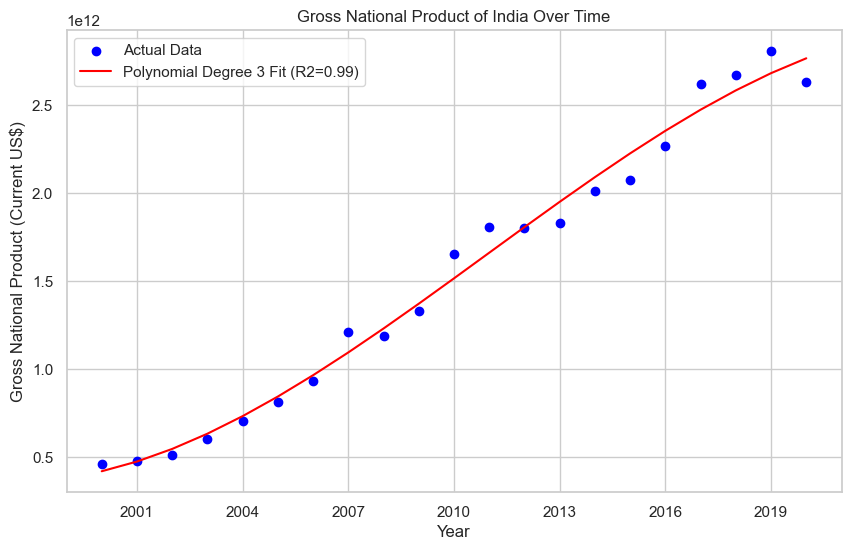

In [63]:
def polynomial_degree_chart():
    # Load the data
    df = pd.read_csv('data.csv', encoding='ascii')

    # Prepare the data for India with the specified Series Code
    india_data = df[(df['Country Code'] == 'IND') & (df['Series Code'] == 'NY.GNP.MKTP.CD')]

    # Drop the non-numeric columns to prepare for plotting
    india_data_numeric = india_data.drop(columns=['Series Name', 'Series Code', 'Country Name', 'Country Code'])

    # Convert the year columns to numeric, errors='coerce' will replace non-numeric values with 
    india_data_numeric = india_data_numeric.apply(pd.to_numeric, errors='coerce')

    # Drop rows with any  values
    india_data_numeric = india_data_numeric.dropna(axis=1)

    # Extract years and values for plotting
    years = np.array([int(year[:4]) for year in india_data_numeric.columns]).reshape(-1, 1)
    values = india_data_numeric.values.reshape(-1, 1)

    # # Plotting the scatter plot
    # plt.figure(figsize=(10, 6))
    # plt.scatter(years, values, color='blue', label='Actual Data')

    # # Fit a polynomial regression model
    degree = 3
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(years)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, values)
    y_poly_pred = poly_model.predict(X_poly)

    # # Calculate R2 score for the polynomial model
    r2 = r2_score(values, y_poly_pred)

    # # Plot the polynomial regression line
    # plt.plot(years, y_poly_pred, color='red', label=f'Polynomial Degree {degree} Fit (R2={r2:.2f})')

    # # Add labels and legend
    # plt.xlabel('Year')
    # plt.ylabel('Gross National Product (Current US$)')
    # plt.title('Gross National Product of India Over Time')
    # plt.legend()

    # # Show plot with best fitting function and confidence rate
    # plt.show()


    # Plotting the scatter plot again
    plt.figure(figsize=(10, 6))
    plt.scatter(years, values, color='blue', label='Actual Data')

    # Plot the polynomial regression line
    plt.plot(years, y_poly_pred, color='red', label=f'Polynomial Degree {degree} Fit (R2={r2:.2f})')

    # Format the x-axis to show years without decimal points
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Add labels and legend
    plt.xlabel('Year')
    plt.ylabel('Gross National Product (Current US$)')
    plt.title('Gross National Product of India Over Time')
    plt.legend()

    # Show plot with best fitting function and confidence rate
    return plt.show()
    
polynomial_degree_chart()

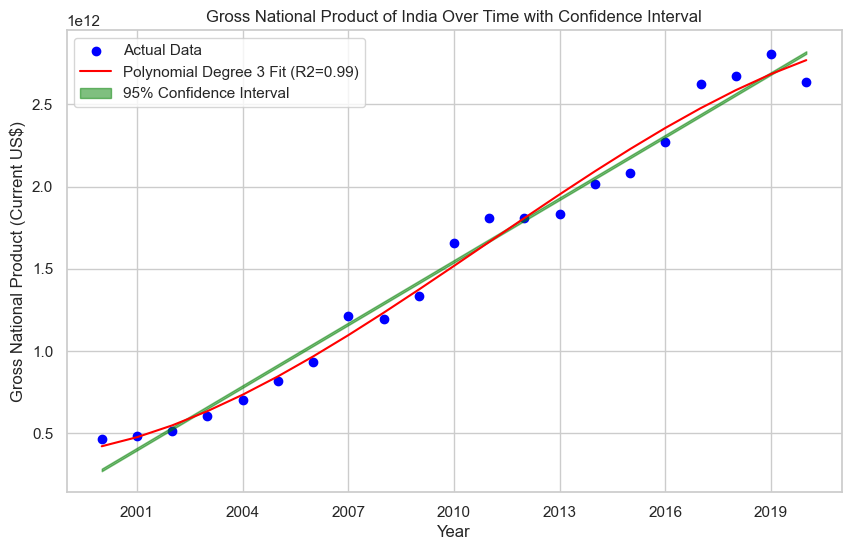

In [65]:
def polynomial_confi():
    
    # Load the data
    df = pd.read_csv('data.csv', encoding='ascii')

    # Prepare the data for India with the specified Series Code
    india_data = df[(df['Country Code'] == 'IND') & (df['Series Code'] == 'NY.GNP.MKTP.CD')]

    # Drop the non-numeric columns to prepare for plotting
    india_data_numeric = india_data.drop(columns=['Series Name', 'Series Code', 'Country Name', 'Country Code'])

    # Convert the year columns to numeric, errors='coerce' will replace non-numeric values with 
    india_data_numeric = india_data_numeric.apply(pd.to_numeric, errors='coerce')

    # Drop rows with any  values
    india_data_numeric = india_data_numeric.dropna(axis=1)

    # Extract years and values for plotting
    years = np.array([int(year[:4]) for year in india_data_numeric.columns]).reshape(-1, 1)
    values = india_data_numeric.values.reshape(-1, 1)


    # Calculate the linear regression parameters
    slope, intercept, r_value, p_value, std_err = linregress(years.ravel(), values.ravel())

    # Create a function for the line of best fit
    fit = lambda x: slope * x + intercept

    # Calculate the confidence interval
    # The factor 1.96 is for 95% confidence interval
    confidence_interval = 1.96 * std_err

    # Calculate the upper and lower bounds of the confidence interval
    lower_bound = fit(years) - confidence_interval
    upper_bound = fit(years) + confidence_interval

    # Plotting the scatter plot again
    plt.figure(figsize=(10, 6))
    plt.scatter(years, values, color='blue', label='Actual Data')

    # Plot the polynomial regression line
    plt.plot(years, y_poly_pred, color='red', label=f'Polynomial Degree {degree} Fit (R2={r2:.2f})')

    # Plot the confidence interval
    plt.fill_between(years.ravel(), lower_bound.ravel(), upper_bound.ravel(), color='green', alpha=0.5, label='95% Confidence Interval')

    # Format the x-axis to show years without decimal points
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Add labels and legend
    plt.xlabel('Year')
    plt.ylabel('Gross National Product (Current US$)')
    plt.title('Gross National Product of India Over Time with Confidence Interval')
    plt.legend()

    # Show plot with best fitting function and confidence rate
    return plt.show()

polynomial_confi()


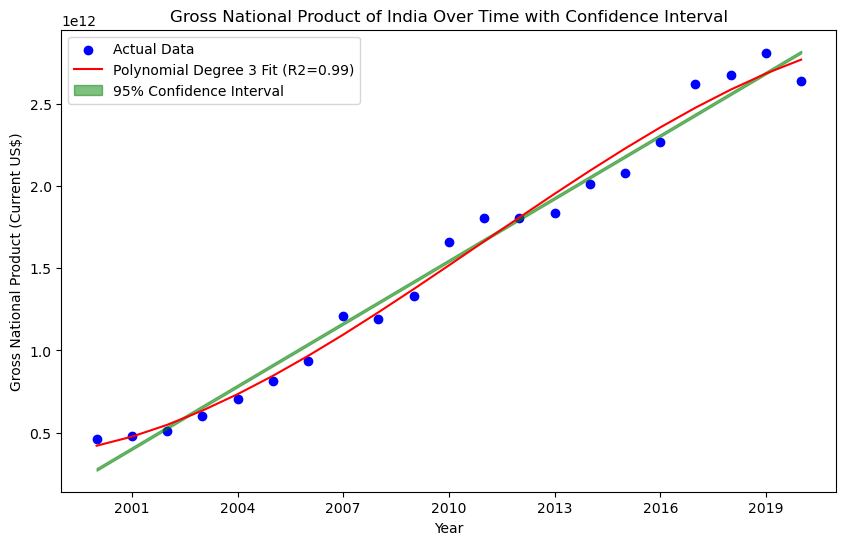

In [46]:


# Calculate the linear regression parameters
slope, intercept, r_value, p_value, std_err = linregress(years.ravel(), values.ravel())

# Create a function for the line of best fit
fit = lambda x: slope * x + intercept

# Calculate the confidence interval
# The factor 1.96 is for 95% confidence interval
confidence_interval = 1.96 * std_err

# Calculate the upper and lower bounds of the confidence interval
lower_bound = fit(years) - confidence_interval
upper_bound = fit(years) + confidence_interval

# Plotting the scatter plot again
plt.figure(figsize=(10, 6))
plt.scatter(years, values, color='blue', label='Actual Data')

# Plot the polynomial regression line
plt.plot(years, y_poly_pred, color='red', label=f'Polynomial Degree {degree} Fit (R2={r2:.2f})')

# Plot the confidence interval
plt.fill_between(years.ravel(), lower_bound.ravel(), upper_bound.ravel(), color='green', alpha=0.5, label='95% Confidence Interval')

# Format the x-axis to show years without decimal points
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Gross National Product (Current US$)')
plt.title('Gross National Product of India Over Time with Confidence Interval')
plt.legend()

# Show plot with best fitting function and confidence rate
plt.show()

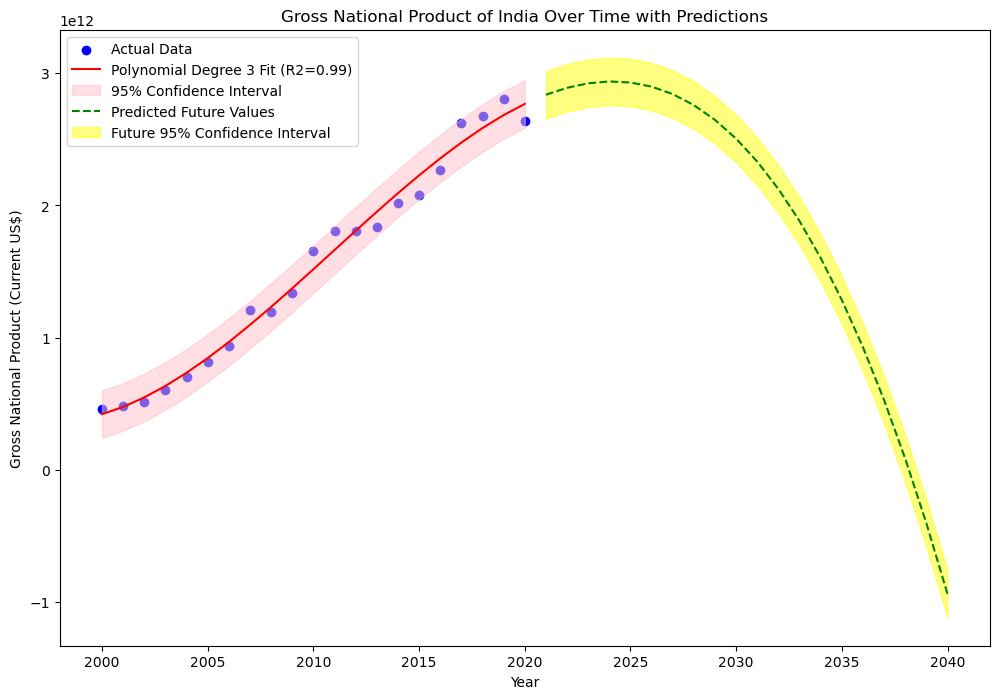

Updated chart with confidence interval and future predictions displayed.


In [47]:
# # Define a range of years for prediction (20 years into the future)
# future_years = np.arange(years[-1] + 1, years[-1] + 21).reshape(-1, 1)

# # Use the existing polynomial model to predict future values
# future_values = poly_model.predict(poly_features.transform(future_years))

# # Calculate the mean squared error of the model
# mse = mean_squared_error(values, y_poly_pred)

# # Calculate the standard deviation of the predictions
# std_dev = np.sqrt(mse)

# # Calculate the confidence interval for the predictions
# confidence_range = 1.96 * std_dev

# # Calculate the upper and lower bounds of the confidence interval for future predictions
# lower_bound_future = future_values - confidence_range
# upper_bound_future = future_values + confidence_range

# # Plotting the scatter plot with the existing data
# plt.figure(figsize=(12, 8))
# plt.scatter(years, values, color='blue', label='Actual Data')
# plt.plot(years, y_poly_pred, color='red', label=f'Polynomial Degree {degree} Fit (R2={r2:.2f})')

# # Plot the confidence interval for the existing data
# plt.fill_between(years.ravel(), (y_poly_pred - confidence_range).ravel(), (y_poly_pred + confidence_range).ravel(), color='pink', alpha=0.5, label='95% Confidence Interval')

# # Plot the predicted values for the next 20 years
# plt.plot(future_years, future_values, color='green', linestyle='--', label='Predicted Future Values')

# # Plot the confidence interval for the future predictions
# plt.fill_between(future_years.ravel(), lower_bound_future.ravel(), upper_bound_future.ravel(), color='yellow', alpha=0.5, label='Future 95% Confidence Interval')

# # Format the x-axis to show years without decimal points
# plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# # Add labels and legend
# plt.xlabel('Year')
# plt.ylabel('Gross National Product (Current US$)')
# plt.title('Gross National Product of India Over Time with Predictions')
# plt.legend()

# # Show plot with best fitting function, confidence interval, and future predictions
# plt.show()
# print('Updated chart with confidence interval and future predictions displayed.')

In [48]:

def plot_prediction(data, series_code, country_name):
    # Filter for United Kingdom and the specific series code
    # 'NY.GNP.MKTP.CD'
    # data = data[(data['Country Name'] == 'United Kingdom') & (data['Series Code'] == series_code)]
    data = data[(data['Country Name'] == country_name) & (data['Series Code'] == series_code)]

    # Clean the year column names by removing the extra text
    country_data_numeric = data.drop(columns=['Country Name', 'Country Code', 'Series Name', 'Series Code'])
    country_data_numeric.columns = [col.split()[0] for col in country_data_numeric.columns]

    # Convert the year columns to integers and values to numeric
    country_data_numeric = country_data_numeric.apply(pd.to_numeric, errors='coerce').dropna(axis=1)
    years_country = np.array([int(year) for year in country_data_numeric.columns]).reshape(-1, 1)
    values_country = country_data_numeric.values.reshape(-1, 1)

    # Fit polynomial regression model
    degree = 3
    poly_reg = PolynomialFeatures(degree=degree)
    X_poly_country = poly_reg.fit_transform(years_country)
    poly_model_country = LinearRegression()
    poly_model_country.fit(X_poly_country, values_country)
    y_poly_pred_country = poly_model_country.predict(X_poly_country)

    # Predict for the next 20 years
    future_years_country = np.arange(years_country[-1] + 1, years_country[-1] + 21).reshape(-1, 1)
    future_values_country = poly_model_country.predict(poly_reg.transform(future_years_country))

    # Calculate confidence interval
    mse_country = mean_squared_error(values_country, y_poly_pred_country)
    std_dev_country = np.sqrt(mse_country)
    confidence_range_country = 1.96 * std_dev_country

    # Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(years_country, values_country, color='blue', label='Actual Data')
    plt.plot(years_country, y_poly_pred_country, color='red', label=f'Polynomial Degree {degree} Fit')
    plt.fill_between(years_country.ravel(), (y_poly_pred_country - confidence_range_country).ravel(), (y_poly_pred_country + confidence_range_country).ravel(), color='pink', alpha=0.5, label='95% Confidence Interval')
    plt.plot(future_years_country, future_values_country, color='green', linestyle='--', label='Predicted Future Values')
    plt.fill_between(future_years_country.ravel(), (future_values_country - confidence_range_country).ravel(), (future_values_country + confidence_range_country).ravel(), color='yellow', alpha=0.5, label='Future 95% Confidence Interval')
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.xlabel('Year')
    plt.ylabel('Gross National Product (Current US$)')
    plt.title(f'Gross National Product of {country_name} Over Time with Predictions')
    plt.legend()
    return plt.show()

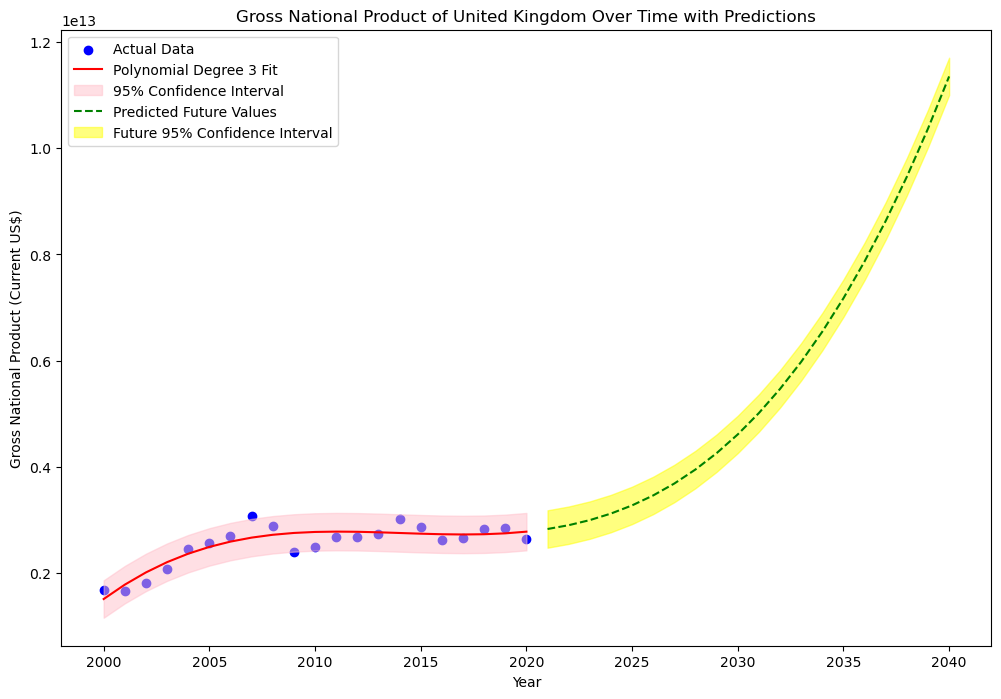

In [49]:
plot_prediction(data, 'NY.GNP.MKTP.CD', 'United Kingdom')

In [50]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Filter the data for 'Access to electricity (% of population)'
# electricity_data = data[data['Series Name'] == 'Access to electricity (% of population)']

# # Drop non-numeric columns and convert year columns to numeric
# electricity_data_numeric = electricity_data.drop(columns=['Series Name', 'Series Code', 'Country Name', 'Country Code'])
# electricity_data_numeric = electricity_data_numeric.apply(pd.to_numeric, errors='coerce')

# # Transpose the dataframe for easier plotting
# electricity_data_transposed = electricity_data_numeric.T

# # Rename the columns with the country names for clarity
# electricity_data_transposed.columns = electricity_data['Country Name']

# # Plotting
# plt.figure(figsize=(14, 8))
# sns.set(style='whitegrid')
# for country in electricity_data_transposed.columns:
#     plt.plot(electricity_data_transposed.index, electricity_data_transposed[country], label=country)

# plt.title('Access to Electricity Over Time')
# plt.xlabel('Year')
# plt.ylabel('Percentage of Population with Access')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# print('Visualization for Access to Electricity over time for all countries in the dataset.')

In [51]:
# def countries_line_plots(data, selected_countries):
#     # Filter the data for 'Access to electricity (% of population)'
#     countries_data = data[data['Series Name'] == 'Access to electricity (% of population)']

#     # Correcting the typo in the country list
#     # selected_countries = ['United States', 'United Kingdom', 'India', 'Nigeria']

#     # Filter the data for the selected countries
#     selected_countries_data = countries_data[countries_data['Country Name'].isin(selected_countries)]

#     # Drop non-numeric columns and convert year columns to numeric
#     selected_countries_data_numeric = selected_countries_data.drop(columns=['Series Name', 'Series Code', 'Country Name', 'Country Code'])
#     selected_countries_data_numeric = selected_countries_data_numeric.apply(pd.to_numeric, errors='coerce')

#     # Transpose the dataframe for easier plotting
#     selected_countries_data_transposed = selected_countries_data_numeric.T

#     # Rename the columns with the country names for clarity
#     selected_countries_data_transposed.columns = selected_countries_data['Country Name']
    
#     # Cleaning the year columns to remove the extra text and convert to integer
#     selected_electricity_data_numeric.columns = selected_electricity_data_numeric.columns.str.extract('(\d+)')[0].astype(int)
#     # Now the columns are just integers, we can use them directly
#     years = selected_electricity_data_numeric.columns
    
#     # Plotting
#     plt.figure(figsize=(14, 8))
#     sns.set(style='whitegrid')
#     for country in selected_countries_data_transposed.columns:
#         plt.plot(years, selected_countries_data_transposed[country], label=country, marker='o')

#     plt.title('Access to Electricity Over Time (Selected Countries)')
#     plt.xlabel('Year')
#     plt.ylabel('Percentage of Population with Access')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     return plt.show()

In [57]:
def countries_line_plots(data, countries_selected, title, series_code):
    # Filter the data that matches series    
    countries_data = data[data['Series Code'] == series_code]


    # Filter the data for the selected countries
    countries_selected_data = countries_data[countries_data['Country Name'].isin(countries_selected)]

    # Drop non-numeric columns and convert year columns to numeric
    countries_selected_data_numeric = countries_selected_data.drop(columns=['Series Name', 'Series Code', 'Country Name', 'Country Code'])
    countries_selected_data_numeric = countries_selected_data_numeric.apply(pd.to_numeric, errors='coerce')

    # Cleaning the year columns to remove the extra text and convert to integer
    countries_selected_data_numeric.columns = countries_selected_data_numeric.columns.str.extract('(\\d+)')[0].astype(int)

    # Transpose the dataframe for easier plotting
    countries_selected_data_transposed = countries_selected_data_numeric.T

    # Rename the columns with the country names for clarity
    countries_selected_data_transposed.columns = countries_selected_data['Country Name']

    # Plotting with numeric x-axis labels
    plt.figure(figsize=(14, 8))
    sns.set(style='whitegrid')

    # Now the columns are just integers, we can use them directly
    years = countries_selected_data_numeric.columns

    for country in countries_selected_data_transposed.columns:
        plt.plot(years, countries_selected_data_transposed[country], label=country, marker='o')

    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Percentage of Population with Access')
    plt.legend()
    plt.xticks(years, rotation=45)  # Set x-ticks to be the years
    plt.tight_layout()
    return plt.show()

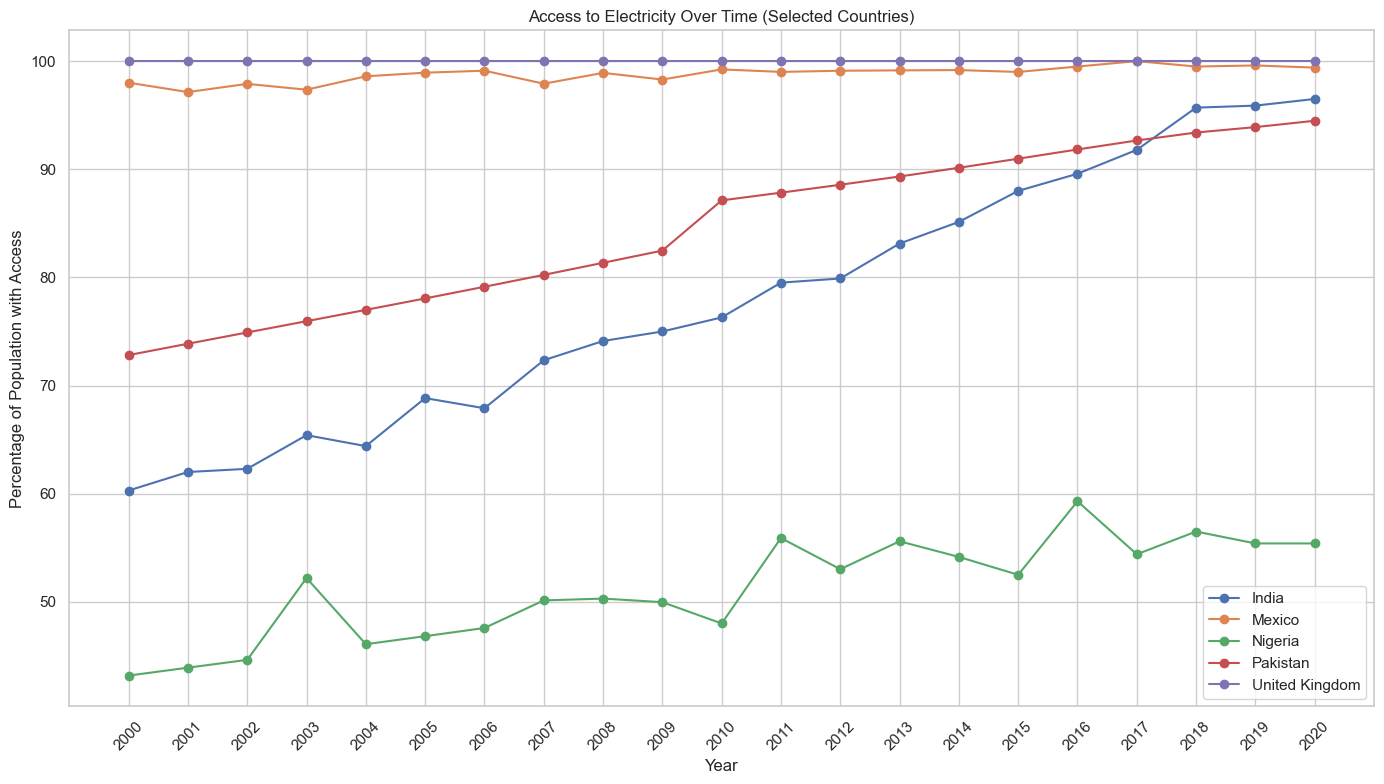

In [61]:
countries_list = ['Mexico', 'United Kingdom', 'India', 'Nigeria', 'Pakistan']
title = 'Access to Electricity Over Time (Selected Countries)'
series_code = 'EG.ELC.ACCS.ZS'
countries_line_plots(data, countries_list, title, series_code)

In [62]:
# ['EG.ELC.ACCS.ZS', 'SP.POP.TOTL', 'SL.TLF.TOTL.IN', 'EN.ATM.METH.KT.CE', 
#  'EN.ATM.CO2E.KT', 'AG.LND.ARBL.ZS', 'AG.LND.FRST.ZS', 'NY.GDP.TOTL.RT.ZS', 'SP.URB.TOTL.IN.ZS', 
#  'BG.GSR.NFSV.GD.ZS', 'NY.GDP.MKTP.KN', 'NY.GNP.MKTP.CD']

In [55]:
def plot_country_confidence(country_name, series_code, title):
    # Filter the data for India and the series code 'NY.GNP.MKTP.CD'
    selected_country = data[(data['Country Name'] == country_name) & (data['Series Code'] == series_code)]

    # Drop the non-year columns to focus on the yearly data
    sel_columns = ['Series Name', 'Series Code', 'Country Name', 'Country Code']
    selected_country_years = selected_country.drop(columns=sel_columns)


    # Since there was an error with 'Unnamed: 0', we will exclude it from the drop
    selected_country_years = selected_country.drop(columns=sel_columns)

    # Transpose the data to have years as rows
    selected_country_transposed = selected_country_years.transpose()
    selected_country_transposed.columns = ['GNP']

    # Reset index to have years as a column
    selected_country_transposed.reset_index(inplace=True)
    selected_country_transposed.rename(columns={'index': 'Year'}, inplace=True)

    # Extract year from the column name and convert to integer
    selected_country_transposed['Year'] = selected_country_transposed['Year'].str.extract('(\d+)').astype(int)

    # Convert GNP column to numeric, coerce errors to NaN
    selected_country_transposed['GNP'] = pd.to_numeric(selected_country_transposed['GNP'], errors='coerce')

    # Drop rows with NaN values
    selected_country_cleaned = selected_country_transposed.dropna()

    # Fit the linear model to the data
    popt, pcov = curve_fit(linear_fit, selected_country_cleaned['Year'], selected_country_cleaned['GNP'])

    # Generate the confidence range
    years = np.array(selected_country_cleaned['Year'])
    GNP, GNP_lower, GNP_upper = err_ranges(years, popt, pcov)

    # Plot the data
    plt.figure(figsize=(14, 7))
    plt.plot(selected_country_cleaned['Year'], selected_country_cleaned['GNP'], 'o', label='Data')
    plt.plot(years, GNP, '-', label='Fit')
    plt.fill_between(years, GNP_lower, GNP_upper, color='gray', alpha=0.2, label='Confidence range')

    # Label the plot
    plt.xlabel('Year')
    plt.ylabel('GNP (current US$)')
    plt.title('GNP of India with Confidence Range')
    plt.legend()

    # Show the plot
    plt.show()

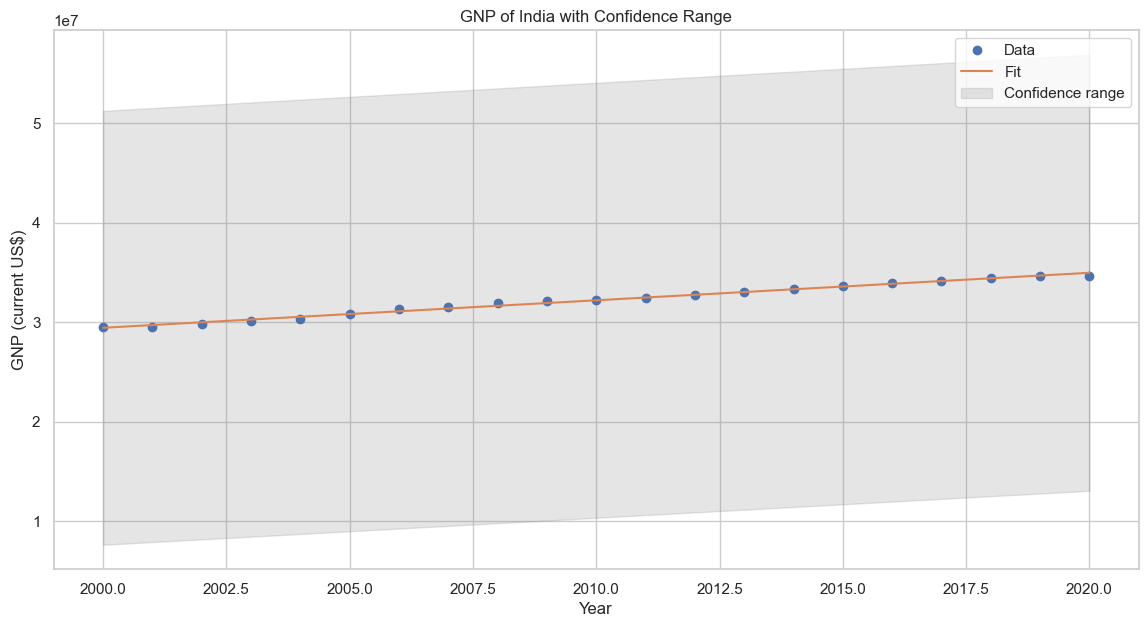

In [56]:
country_name = 'United Kingdom'
series_code = 'SL.TLF.TOTL.IN'
title = ''
plot_country_confidence(country_name, series_code, title)